In [2]:
from numpy import *
from matplotlib.pylab import *
import random
import sys
import io
import os
import glob
import h5py

import IPython

#from pydub import AudioSegment
from td_utils import *

/users/bssn/serna/environments/deepl/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
from keras.callbacks import ModelCheckpoint
from keras.models import Model, load_model, Sequential
from keras.layers import Dense, Activation, Dropout, Input, Masking, TimeDistributed, LSTM, Conv1D, Concatenate
from keras.layers import GRU, Bidirectional, BatchNormalization, Reshape
from keras.layers import MaxPooling2D, MaxPooling3D, AveragePooling2D, AveragePooling3D
from keras.layers import Conv2D,Conv3D, Lambda
from keras.backend import transpose
from keras.optimizers import Adam
from keras import regularizers

Using TensorFlow backend.


(10, 10, 4000)


<Figure size 432x288 with 0 Axes>

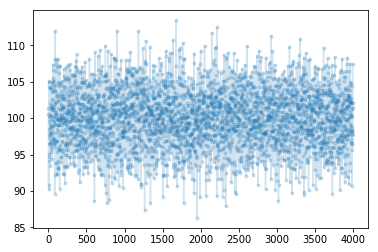

<Figure size 432x288 with 0 Axes>

In [4]:
i = randint(0,900)
home = "/export/home1/users/bssn/serna"
datadir = home+"/SyntheticData/syndat/"
Ft = load(datadir+"d"+str(i).zfill(4)+".npy")

Ftsh = Ft.shape
width,height,T = Ftsh  
print(Ftsh)
t = arange(Ftsh[-1])
figure()
plot(t,sum(sum(Ft,axis=0),axis=0),'.-',alpha=0.2)
figure()

In [5]:
def get_random_time_segment(segment_frames,total_frames=12000):
    '''
    Gets a random time segment of duration segment_frames in a file
    with number of frames: total_frames
    '''
    
    segment_start = randint(0, high = total_frames-
                                   segment_frames)
    segment_end = segment_start + segment_frames
    
    return (segment_start, segment_end)

In [6]:
def is_overlapping(segment_time, previous_segments):
    '''
    This function checks if the time of a segment overlaps with the
    existing segments.
    '''
    s_start, s_end = segment_time
    
    overlap = False
    
    for prev_start, prev_end in previous_segments:
        if s_start <= prev_end and s_end >= prev_start:
            overlap = True
    
    return overlap

## Loading data set.

This is a big dataset, so we are going to divide it in 4000 samples for  training set and 100 dev_set and 100 test_set.

In [149]:
def readdata():
    nframes = 500
    magn=2

    X = zeros((800,width*magn,height*magn,nframes))
    Y = zeros((800,width*magn,height*magn))

    for i in range(800):
        xt = load(datadir+"d"+str(i).zfill(4)+".npy")
        yt = load(datadir+"o"+str(magn)+"_"+str(i).zfill(4)+".npy") 
        xt = xt/mean(xt.flatten())
        xt = ftvaugment(xt,magn)
        ymax = max(1,max(yt.flatten()))
        yt = yt
        start,end = get_random_time_segment(nframes,T)
        X[i,:,:,:] = xt[:,:,start:end]
        Y[i,:,:] = (yt)/ymax
    X = array(X)
    Y = array(Y)
    X = reshape(X,(X.shape[0],X.shape[1],X.shape[2],X.shape[3],1))
    Y = reshape(Y,(Y.shape[0],Y.shape[1],Y.shape[2],1,1))
    return(X,Y)

In [7]:
from scipy.fftpack import fft2,fftshift,ifftshift,ifft2

def ftaugment(img,magn=2):
    sh = img.shape
    sh2 = (sh*(magn-1))
    sh2 = ((sh2[0])//2,(sh2[1])//2)
    fftim  = fftshift(fft2(img))
    fftim  =  pad(fftim,(sh2[0],sh2[1]),'constant')    
    imgn = real(ifft2(ifftshift(fftim)))
    return(imgn)

def ftvaugment(img,magn=2):
    sh = img.shape
    sh2 = array([sh[0],sh[1]])*(magn-1)
    sh2 = ((sh2[0])//2,(sh2[0])//2)
    fftim  = fftshift(fft2(img,axes=(0,1)),axes=(0,1))
    fftim  =  pad(fftim,(sh2[0],sh2[1]),'constant') 
    imgn = real(ifft2(ifftshift(fftim,axes=(0,1)),axes=(0,1)))
    imgn = imgn[:,:,sh2[0]:-sh2[0]]
    return(imgn)

In [9]:
nframes = 500
magn=2

X = zeros((800,width*magn,height*magn,nframes))
Y = zeros((800,width*magn,height*magn))

for i in range(800):
    xt = load(datadir+"d"+str(i).zfill(4)+".npy")
    yt = load(datadir+"o"+str(magn)+"_"+str(i).zfill(4)+".npy") 
    xt = xt/mean(xt.flatten())
    xt = ftvaugment(xt,magn)
    ymax = max(1,max(yt.flatten()))
    yt = yt
    #par = pars[i]
    #xt = reshape(xt,(width*height,T))
    #yt = reshape(yt,(4*width*height))
    for j in range(1):
        start,end = get_random_time_segment(nframes,T)
        X[i,:,:,:] = xt[:,:,start:end]
        #Y.append(concatenate((yt[start:end],par[-1:])))
        #ytr = 0.05*ymax*randn(magn*width,magn*height)
        Y[i,:,:] = (yt)/ymax
    if i %200 == 0:
        print("Iteracion #",i)
X = array(X)
Y = array(Y)
print(X.shape, Y.shape)
    

Xdev = []
Ydev = []
Xdev = zeros((100,width*magn,height*magn,nframes))
Ydev = zeros((100,width*magn,height*magn))
for i in range(800,900):
    xt = load(datadir+"d"+str(i).zfill(4)+".npy")
    yt = load(datadir+"o"+str(magn)+"_"+str(i).zfill(4)+".npy")
    xt = xt/mean(xt.flatten())
    xt = ftvaugment(xt,magn)
    
    ymax = max(1,max(yt.flatten()))
    yt = yt
    #par = pars[i]
    #xt = reshape(xt,(width*height,T))
    #yt = reshape(yt,(4*width*height))
    for j in range(1):
        start,end = get_random_time_segment(nframes,T)
        Xdev[i-800,:,:,:] = xt[:,:,start:end]
        #Y.append(concatenate((yt[start:end],par[-1:])))
        #ytr = 0.05*ymax*randn(magn*width,magn*height)
        Ydev[i-800,:,:] = (yt)/ymax
Xdev = array(Xdev)
Ydev = array(Ydev)

print(Xdev.shape, Ydev.shape)



'''
Xdev = array(X).transpose()
Ydev = array(Y).transpose()
for i in range(4000,4100):
    xt = load("syndat/d"+str(i).zfill(4)+".npy")
    yt = load("syndat/r"+str(i).zfill(4)+".npy")
    for j in range(20):
        start,end = get_random_time_segment(nframes)
        Xdev.append(xt[start:end])
        Ydev.append(yt[start:end])
'''        
        

(100, 20, 20, 500) (100, 20, 20)


'\nXdev = array(X).transpose()\nYdev = array(Y).transpose()\nfor i in range(4000,4100):\n    xt = load("syndat/d"+str(i).zfill(4)+".npy")\n    yt = load("syndat/r"+str(i).zfill(4)+".npy")\n    for j in range(20):\n        start,end = get_random_time_segment(nframes)\n        Xdev.append(xt[start:end])\n        Ydev.append(yt[start:end])\n'

In [10]:
Xdev.shape

(100, 20, 20, 500)

27


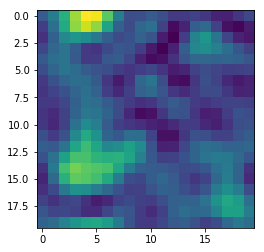

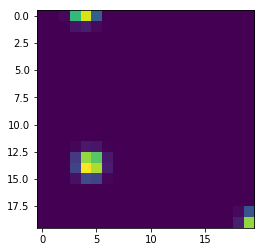

In [11]:
colors = array(['C0','C1'])
t = arange(1000)
# We plot some random pieces we chose to fit the network!

i = randint(0,X.shape[0])
imshow(sum(X[i,:,:],axis=-1))
figure()
imshow(Y[i,:])
print(i)

In [ ]:
print(X.shape)
print(Y.shape)
print(Xdev.shape)
print(Ydev.shape)
width

## Definition of the network

Here, we define the neural network. We may start with just nframes logistic regressions?!

In [12]:
X = reshape(X,(X.shape[0],X.shape[1],X.shape[2],X.shape[3],1))
Y = reshape(Y,(Y.shape[0],Y.shape[1],Y.shape[2],1,1))

Xdev = reshape(Xdev,(Xdev.shape[0],Xdev.shape[1],Xdev.shape[2],Xdev.shape[3],1))
Ydev = reshape(Ydev,(Ydev.shape[0],Ydev.shape[1],Ydev.shape[2],1,1))

In [13]:
print(X.shape,Y.shape)

(800, 20, 20, 500, 1) (800, 20, 20, 1, 1)


In [23]:
def model(input_shape):
    '''
    Function used to create the model's graph in Keras
    
    Argument:
    -- input_shape. Shape of the model's input data (Keras conventions?!)
    
    Returns:
    -- model. Keras model instance
    '''

    X_input = Input(shape = input_shape)
    
    w,h,T,_ = input_shape
    # Layers

    X = X_input
    
    Xa = MaxPooling3D((2,2,40),strides=(1,1,5),padding="same")(X)
    Xb = AveragePooling3D((2,2,40),strides=(1,1,5),padding="same")(X)
    Xa2 =  Lambda(lambda x: x * x)(Xa)
    Xb2 = Lambda(lambda x: x * x)(Xb)
    Xa3 =  Lambda(lambda x: x **3)(Xa)
    Xb3 = Lambda(lambda x: x **3)(Xb)
    Xa4 =  Lambda(lambda x: x **4)(Xa)
    Xb4 = Lambda(lambda x: x **4)(Xb)

    X = Concatenate()([Xa,Xb,Xa2,Xb2,Xa3,Xb3,Xa4,Xb4])
    X = BatchNormalization()(X)   

    X = Dropout(0.3)(X)
    
    X = Conv3D(80,(4,4,8),strides=(1,1,3),padding="same")(X)
    X = Activation("relu")(X)
    X = BatchNormalization()(X)
    
    X = Dropout(0.3)(X)
    X = AveragePooling3D((4,4,20),strides=(1,1,3),padding="same")(X)
    X = BatchNormalization()(X)   
   
    X = Dropout(0.3)(X)
    X = Conv3D(40,(1,1,12),strides=(1,1,12),padding="valid")(X)
    X = Activation("relu")(X)
    X = BatchNormalization()(X) 

    
    #X = Dropout(0.3)(X)
    #X = MaxPooling3D((1,1,10),strides=(1,1,1),padding="same")(X)
    #X = Activation("relu")(X)
    #X = BatchNormalization()(X) 

    #X = Dropout(0.3)(X)
    #X = Conv3D(80,(1,1,10),strides=(1,1,2),padding="valid")(X)
    #X = Activation("relu")(X)
    #X = BatchNormalization()(X) 
    X = Dropout(0.3)(X)
    X = Dense(20,activation="relu")(X)
    X = BatchNormalization()(X) 

    X = Dropout(0.3)(X)
    X = Dense(5,activation="relu")(X)
    X = BatchNormalization()(X) 
    
    
    X = Dropout(0.3)(X)
    X = Dense(1,activation="relu")(X)

    # Defining the model
    
    model = Model(inputs = X_input, outputs = X)
    
    return model

In [24]:
model = model(input_shape = (magn*width,magn*height,nframes,1))

In [25]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 20, 20, 500,  0                                            
__________________________________________________________________________________________________
max_pooling3d_2 (MaxPooling3D)  (None, 20, 20, 100,  0           input_2[0][0]                    
__________________________________________________________________________________________________
average_pooling3d_3 (AveragePoo (None, 20, 20, 100,  0           input_2[0][0]                    
__________________________________________________________________________________________________
lambda_7 (Lambda)               (None, 20, 20, 100,  0           max_pooling3d_2[0][0]            
__________________________________________________________________________________________________
lambda_8 (

### Fit the model!

In [26]:
from keras.optimizers import SGD

In [27]:
import keras.backend as K
def brutal_log(y_true,y_pred):
    '''Just another crossentropy'''
    ly = K.flatten(K.log(y_true+1e-8))
    ly2 = K.flatten(K.log(y_pred+1e-8))

    lyf = K.cast(K.flatten(ly> -100.0),dtype='float32')
    lyf2 = K.cast(K.flatten(ly2> -100.0),dtype='float32')
    lyf = lyf2*lyf
    out = K.mean((ly*lyf-ly2*lyf)**2)+200.0*K.mean(lyf2)
    return out

#Mendel ...
def MOC(y_true,y_pred):
    '''Just another crossentropy'''
    ly = K.sum(y_true*y_pred)
    ly2 = K.sum(y_pred*y_pred)
    ly3 = K.sum(y_true*y_true)
    out = ly/K.sqrt(ly2*ly3)
    return out

def MOCl(y_true,y_pred):
    '''Just another crossentropy'''
    ly = K.sum(y_true*y_pred)
    ly2 = K.sum(y_pred*y_pred)
    ly3 = K.sum(y_true*y_true)
    out = 1.0-ly/K.sqrt(ly2*ly3)
    return out
#Pearson Correlation
def PCC(y_true,y_pred):
    '''Just another crossentropy'''
    lt1 = y_true-K.mean(y_true)
    lt2 = y_pred-K.mean(y_pred)
    
    ly = K.sum(lt1*lt2)
    ly2 = K.sum(lt1*lt1)
    ly3 = K.sum(lt2*lt2)
    out = ly/K.sqrt(ly2*ly3)
    
    return out

def PCCl(y_true,y_pred):
    '''Just another crossentropy'''
    lt1 = y_true-K.mean(y_true)
    lt2 = y_pred-K.mean(y_pred)
    
    ly = K.sum(lt1*lt2)
    ly2 = K.sum(lt1*lt1)
    ly3 = K.sum(lt2*lt2)
    out = ly/K.sqrt(ly2*ly3)
    
    return 1.0-out




In [155]:
opt = Adam(lr=0.05, beta_1=0.7, beta_2=0.999, decay=0.001)
#opt = SGD(lr=100, decay=1e-6, momentum=1.9)

model.compile(loss=PCCl, optimizer=opt, metrics=[MOC])
#model.compile(loss='mean_squared_logarithmic_error', optimizer=opt, metrics=["accuracy"])
#model.compile(loss=brutal_log, optimizer=opt, metrics=["accuracy"])


In [29]:
history = {}
ih = 0

In [30]:
Wsave = model.get_weights()
#model.set_weights(Wsave)

In [150]:
import subprocess


In [153]:
%timeit
X,Y = readdata()
print(X.shape)

(800, 20, 20, 500, 1)


In [154]:
print(Y.shape)

(800, 20, 20, 1, 1)


In [156]:

for j in range(200):

    prGen = subprocess.Popen('./generatemore.sh')

    for i in range(10):
        ytr = 0.05*ymax*randn(Y.shape[0],Y.shape[1],Y.shape[2],1,1)
        Y1 = Y +ytr
        history[ih] = model.fit(X, Y1, batch_size = 100, epochs = 10)
        ih = ih+1

    prGen.wait()
    X,Y = readdata()

print(ih)

Epoch 1/10
800/800 [==============================] - 10s 12ms/step - loss: 0.3384 - MOC: 0.6788
Epoch 2/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3104 - MOC: 0.7054
Epoch 3/10
800/800 [==============================] - 8s 9ms/step - loss: 0.3020 - MOC: 0.7132
Epoch 4/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3023 - MOC: 0.7129
Epoch 5/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3005 - MOC: 0.7146
Epoch 6/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3001 - MOC: 0.7150
Epoch 7/10
800/800 [==============================] - 7s 9ms/step - loss: 0.3030 - MOC: 0.7124
Epoch 8/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2991 - MOC: 0.7159
Epoch 9/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2997 - MOC: 0.7153
Epoch 10/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2942 - MOC: 0.7205
Epoch 1/10
800/800 [===========================

800/800 [==============================] - 7s 9ms/step - loss: 0.2690 - MOC: 0.7443
Epoch 8/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2692 - MOC: 0.7440
Epoch 9/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2646 - MOC: 0.7484
Epoch 10/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2683 - MOC: 0.7448
Epoch 1/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2699 - MOC: 0.7434
Epoch 2/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2670 - MOC: 0.7462
Epoch 3/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2678 - MOC: 0.7455
Epoch 4/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2702 - MOC: 0.7431
Epoch 5/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2701 - MOC: 0.7432
Epoch 6/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2687 - MOC: 0.7447
Epoch 7/10
800/800 [==============================] - 7s 9ms

800/800 [==============================] - 8s 10ms/step - loss: 0.2788 - MOC: 0.7353
Epoch 4/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2797 - MOC: 0.7345
Epoch 5/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2762 - MOC: 0.7378
Epoch 6/10
800/800 [==============================] - 8s 10ms/step - loss: 0.2768 - MOC: 0.7372
Epoch 7/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2769 - MOC: 0.7371
Epoch 8/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2772 - MOC: 0.7369
Epoch 9/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2771 - MOC: 0.7369
Epoch 10/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2774 - MOC: 0.7367
Epoch 1/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2752 - MOC: 0.7387
Epoch 2/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2759 - MOC: 0.7381
Epoch 3/10
800/800 [==============================] - 7s 9

800/800 [==============================] - 8s 9ms/step - loss: 0.2818 - MOC: 0.7321
Epoch 10/10
800/800 [==============================] - 8s 10ms/step - loss: 0.2821 - MOC: 0.7319
Epoch 1/10
800/800 [==============================] - 8s 10ms/step - loss: 0.2811 - MOC: 0.7326
Epoch 2/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2822 - MOC: 0.7315
Epoch 3/10
800/800 [==============================] - 8s 10ms/step - loss: 0.2814 - MOC: 0.7324
Epoch 4/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2824 - MOC: 0.7314
Epoch 5/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2826 - MOC: 0.7312
Epoch 6/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2802 - MOC: 0.7335
Epoch 7/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2801 - MOC: 0.7335
Epoch 8/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2806 - MOC: 0.7330
Epoch 9/10
800/800 [==============================] - 8s 

800/800 [==============================] - 8s 9ms/step - loss: 0.2844 - MOC: 0.7307
Epoch 6/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2834 - MOC: 0.7317
Epoch 7/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2834 - MOC: 0.7317
Epoch 8/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2847 - MOC: 0.7304
Epoch 9/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2821 - MOC: 0.7328
Epoch 10/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2829 - MOC: 0.7321
Epoch 1/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2818 - MOC: 0.7331
Epoch 2/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2841 - MOC: 0.7310
Epoch 3/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2844 - MOC: 0.7306
Epoch 4/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2820 - MOC: 0.7330
Epoch 5/10
800/800 [==============================] - 7s 9ms

800/800 [==============================] - 8s 10ms/step - loss: 0.2793 - MOC: 0.7349
Epoch 2/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2822 - MOC: 0.7321
Epoch 3/10
800/800 [==============================] - 8s 10ms/step - loss: 0.2807 - MOC: 0.7335
Epoch 4/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2822 - MOC: 0.7321
Epoch 5/10
800/800 [==============================] - 8s 10ms/step - loss: 0.2803 - MOC: 0.7339
Epoch 6/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2806 - MOC: 0.7336
Epoch 7/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2803 - MOC: 0.7339
Epoch 8/10
800/800 [==============================] - 8s 10ms/step - loss: 0.2765 - MOC: 0.7375
Epoch 9/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2798 - MOC: 0.7343
Epoch 10/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2784 - MOC: 0.7357
Epoch 1/10
800/800 [==============================] - 8s

800/800 [==============================] - 7s 9ms/step - loss: 0.2840 - MOC: 0.7302
Epoch 8/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2829 - MOC: 0.7313
Epoch 9/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2816 - MOC: 0.7325
Epoch 10/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2817 - MOC: 0.7324
Epoch 1/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2832 - MOC: 0.7310
Epoch 2/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2823 - MOC: 0.7318
Epoch 3/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2820 - MOC: 0.7322
Epoch 4/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2812 - MOC: 0.7329
Epoch 5/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2808 - MOC: 0.7332
Epoch 6/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2824 - MOC: 0.7317
Epoch 7/10
800/800 [==============================] - 7s 9ms

800/800 [==============================] - 7s 9ms/step - loss: 0.2846 - MOC: 0.7302
Epoch 4/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2807 - MOC: 0.7338
Epoch 5/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2831 - MOC: 0.7316
Epoch 6/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2809 - MOC: 0.7336
Epoch 7/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2811 - MOC: 0.7335
Epoch 8/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2791 - MOC: 0.7353
Epoch 9/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2800 - MOC: 0.7345
Epoch 10/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2804 - MOC: 0.7340
Epoch 1/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2805 - MOC: 0.7341
Epoch 2/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2788 - MOC: 0.7357
Epoch 3/10
800/800 [==============================] - 7s 9ms

800/800 [==============================] - 8s 9ms/step - loss: 0.2684 - MOC: 0.7454
Epoch 10/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2714 - MOC: 0.7426
Epoch 1/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2706 - MOC: 0.7433
Epoch 2/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2715 - MOC: 0.7424
Epoch 3/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2685 - MOC: 0.7453
Epoch 4/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2707 - MOC: 0.7431
Epoch 5/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2699 - MOC: 0.7439
Epoch 6/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2673 - MOC: 0.7464
Epoch 7/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2693 - MOC: 0.7445
Epoch 8/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2711 - MOC: 0.7428
Epoch 9/10
800/800 [==============================] - 7s 9ms

800/800 [==============================] - 7s 9ms/step - loss: 0.2729 - MOC: 0.7404
Epoch 6/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2721 - MOC: 0.7411
Epoch 7/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2711 - MOC: 0.7420
Epoch 8/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2715 - MOC: 0.7417
Epoch 9/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2714 - MOC: 0.7418
Epoch 10/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2722 - MOC: 0.7410
Epoch 1/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2734 - MOC: 0.7399
Epoch 2/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2726 - MOC: 0.7406
Epoch 3/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2743 - MOC: 0.7390
Epoch 4/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2747 - MOC: 0.7387
Epoch 5/10
800/800 [==============================] - 7s 9ms

800/800 [==============================] - 8s 10ms/step - loss: 0.2795 - MOC: 0.7343
Epoch 2/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2780 - MOC: 0.7358
Epoch 3/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2765 - MOC: 0.7372
Epoch 4/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2787 - MOC: 0.7352
Epoch 5/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2777 - MOC: 0.7362
Epoch 6/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2748 - MOC: 0.7388
Epoch 7/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2775 - MOC: 0.7363
Epoch 8/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2792 - MOC: 0.7347
Epoch 9/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2781 - MOC: 0.7358
Epoch 10/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2780 - MOC: 0.7359
Epoch 1/10
800/800 [==============================] - 7s 9m

800/800 [==============================] - 7s 9ms/step - loss: 0.2770 - MOC: 0.7366
Epoch 8/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2767 - MOC: 0.7369
Epoch 9/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2755 - MOC: 0.7380
Epoch 10/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2748 - MOC: 0.7387
Epoch 1/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2779 - MOC: 0.7357
Epoch 2/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2761 - MOC: 0.7375
Epoch 3/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2783 - MOC: 0.7355
Epoch 4/10
800/800 [==============================] - 8s 10ms/step - loss: 0.2769 - MOC: 0.7367
Epoch 5/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2774 - MOC: 0.7363
Epoch 6/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2753 - MOC: 0.7383
Epoch 7/10
800/800 [==============================] - 8s 10

800/800 [==============================] - 7s 9ms/step - loss: 0.2796 - MOC: 0.7349
Epoch 4/10
800/800 [==============================] - 8s 10ms/step - loss: 0.2803 - MOC: 0.7344
Epoch 5/10
800/800 [==============================] - 8s 10ms/step - loss: 0.2789 - MOC: 0.7357
Epoch 6/10
800/800 [==============================] - 8s 10ms/step - loss: 0.2812 - MOC: 0.7335
Epoch 7/10
800/800 [==============================] - 8s 10ms/step - loss: 0.2795 - MOC: 0.7351
Epoch 8/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2808 - MOC: 0.7339
Epoch 9/10
800/800 [==============================] - 8s 10ms/step - loss: 0.2789 - MOC: 0.7356
Epoch 10/10
800/800 [==============================] - 8s 10ms/step - loss: 0.2786 - MOC: 0.7359
Epoch 1/10
800/800 [==============================] - 8s 10ms/step - loss: 0.2819 - MOC: 0.7329
Epoch 2/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2792 - MOC: 0.7354
Epoch 3/10
800/800 [==============================] -

800/800 [==============================] - 7s 9ms/step - loss: 0.2861 - MOC: 0.7279
Epoch 10/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2864 - MOC: 0.7276
Epoch 1/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2856 - MOC: 0.7285
Epoch 2/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2859 - MOC: 0.7282
Epoch 3/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2863 - MOC: 0.7278
Epoch 4/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2848 - MOC: 0.7293
Epoch 5/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2860 - MOC: 0.7280
Epoch 6/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2866 - MOC: 0.7274
Epoch 7/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2865 - MOC: 0.7276
Epoch 8/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2860 - MOC: 0.7280
Epoch 9/10
800/800 [==============================] - 7s 9ms

800/800 [==============================] - 8s 9ms/step - loss: 0.2852 - MOC: 0.7287
Epoch 6/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2852 - MOC: 0.7287
Epoch 7/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2855 - MOC: 0.7284
Epoch 8/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2829 - MOC: 0.7309
Epoch 9/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2817 - MOC: 0.7320
Epoch 10/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2811 - MOC: 0.7325
Epoch 1/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2840 - MOC: 0.7297
Epoch 2/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2838 - MOC: 0.7300
Epoch 3/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2819 - MOC: 0.7318
Epoch 4/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2809 - MOC: 0.7327
Epoch 5/10
800/800 [==============================] - 7s 9ms

800/800 [==============================] - 8s 9ms/step - loss: 0.2760 - MOC: 0.7372
Epoch 2/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2749 - MOC: 0.7383
Epoch 3/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2775 - MOC: 0.7359
Epoch 4/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2739 - MOC: 0.7393
Epoch 5/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2755 - MOC: 0.7377
Epoch 6/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2763 - MOC: 0.7369
Epoch 7/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2767 - MOC: 0.7366
Epoch 8/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2763 - MOC: 0.7370
Epoch 9/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2767 - MOC: 0.7365
Epoch 10/10
800/800 [==============================] - 8s 10ms/step - loss: 0.2755 - MOC: 0.7377
Epoch 1/10
800/800 [==============================] - 7s 9m

800/800 [==============================] - 7s 9ms/step - loss: 0.2704 - MOC: 0.7432
Epoch 8/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2721 - MOC: 0.7416
Epoch 9/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2707 - MOC: 0.7428
Epoch 10/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2696 - MOC: 0.7439
Epoch 1/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2698 - MOC: 0.7439
Epoch 2/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2715 - MOC: 0.7422
Epoch 3/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2719 - MOC: 0.7418
Epoch 4/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2697 - MOC: 0.7439
Epoch 5/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2714 - MOC: 0.7422
Epoch 6/10
800/800 [==============================] - 8s 10ms/step - loss: 0.2714 - MOC: 0.7424
Epoch 7/10
800/800 [==============================] - 7s 9m

800/800 [==============================] - 8s 9ms/step - loss: 0.2802 - MOC: 0.7338
Epoch 4/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2824 - MOC: 0.7317
Epoch 5/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2806 - MOC: 0.7335
Epoch 6/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2803 - MOC: 0.7337
Epoch 7/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2804 - MOC: 0.7337
Epoch 8/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2802 - MOC: 0.7338
Epoch 9/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2803 - MOC: 0.7338
Epoch 10/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2795 - MOC: 0.7345
Epoch 1/10
800/800 [==============================] - 8s 10ms/step - loss: 0.2799 - MOC: 0.7342
Epoch 2/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2814 - MOC: 0.7328
Epoch 3/10
800/800 [==============================] - 7s 9m

800/800 [==============================] - 7s 9ms/step - loss: 0.2750 - MOC: 0.7388
Epoch 10/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2762 - MOC: 0.7377
Epoch 1/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2742 - MOC: 0.7396
Epoch 2/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2759 - MOC: 0.7380
Epoch 3/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2755 - MOC: 0.7383
Epoch 4/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2758 - MOC: 0.7380
Epoch 5/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2764 - MOC: 0.7374
Epoch 6/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2750 - MOC: 0.7389
Epoch 7/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2751 - MOC: 0.7387
Epoch 8/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2764 - MOC: 0.7375
Epoch 9/10
800/800 [==============================] - 7s 9ms

800/800 [==============================] - 8s 9ms/step - loss: 0.2797 - MOC: 0.7344
Epoch 6/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2802 - MOC: 0.7340
Epoch 7/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2801 - MOC: 0.7341
Epoch 8/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2773 - MOC: 0.7367
Epoch 9/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2784 - MOC: 0.7357
Epoch 10/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2800 - MOC: 0.7341
Epoch 1/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2803 - MOC: 0.7337
Epoch 2/10
800/800 [==============================] - 8s 10ms/step - loss: 0.2769 - MOC: 0.7370
Epoch 3/10
800/800 [==============================] - 8s 10ms/step - loss: 0.2794 - MOC: 0.7347
Epoch 4/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2789 - MOC: 0.7351
Epoch 5/10
800/800 [==============================] - 8s 1

800/800 [==============================] - 7s 9ms/step - loss: 0.2752 - MOC: 0.7387
Epoch 2/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2765 - MOC: 0.7375
Epoch 3/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2746 - MOC: 0.7393
Epoch 4/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2742 - MOC: 0.7396
Epoch 5/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2757 - MOC: 0.7382
Epoch 6/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2739 - MOC: 0.7399
Epoch 7/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2756 - MOC: 0.7383
Epoch 8/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2754 - MOC: 0.7384
Epoch 9/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2750 - MOC: 0.7388
Epoch 10/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2751 - MOC: 0.7387
Epoch 1/10
800/800 [==============================] - 7s 9ms

800/800 [==============================] - 7s 9ms/step - loss: 0.2830 - MOC: 0.7312
Epoch 8/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2805 - MOC: 0.7336
Epoch 9/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2812 - MOC: 0.7330
Epoch 10/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2810 - MOC: 0.7332
Epoch 1/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2829 - MOC: 0.7313
Epoch 2/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2798 - MOC: 0.7343
Epoch 3/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2813 - MOC: 0.7328
Epoch 4/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2807 - MOC: 0.7334
Epoch 5/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2780 - MOC: 0.7360
Epoch 6/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2797 - MOC: 0.7344
Epoch 7/10
800/800 [==============================] - 8s 9ms

800/800 [==============================] - 8s 9ms/step - loss: 0.2735 - MOC: 0.7402
Epoch 4/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2757 - MOC: 0.7382
Epoch 5/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2766 - MOC: 0.7374
Epoch 6/10
800/800 [==============================] - 8s 10ms/step - loss: 0.2749 - MOC: 0.7389
Epoch 7/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2741 - MOC: 0.7397
Epoch 8/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2726 - MOC: 0.7412
Epoch 9/10
800/800 [==============================] - 8s 10ms/step - loss: 0.2743 - MOC: 0.7395
Epoch 10/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2741 - MOC: 0.7397
Epoch 1/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2766 - MOC: 0.7373
Epoch 2/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2763 - MOC: 0.7375
Epoch 3/10
800/800 [==============================] - 7s 9

800/800 [==============================] - 7s 9ms/step - loss: 0.2691 - MOC: 0.7443
Epoch 10/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2697 - MOC: 0.7437
Epoch 1/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2680 - MOC: 0.7452
Epoch 2/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2689 - MOC: 0.7445
Epoch 3/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2677 - MOC: 0.7456
Epoch 4/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2678 - MOC: 0.7455
Epoch 5/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2680 - MOC: 0.7453
Epoch 6/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2688 - MOC: 0.7446
Epoch 7/10
800/800 [==============================] - 8s 10ms/step - loss: 0.2691 - MOC: 0.7441
Epoch 8/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2679 - MOC: 0.7453
Epoch 9/10
800/800 [==============================] - 8s 10

800/800 [==============================] - 7s 9ms/step - loss: 0.2714 - MOC: 0.7420
Epoch 6/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2705 - MOC: 0.7429
Epoch 7/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2709 - MOC: 0.7425
Epoch 8/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2712 - MOC: 0.7423
Epoch 9/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2694 - MOC: 0.7439
Epoch 10/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2721 - MOC: 0.7414
Epoch 1/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2717 - MOC: 0.7419
Epoch 2/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2710 - MOC: 0.7427
Epoch 3/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2716 - MOC: 0.7421
Epoch 4/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2698 - MOC: 0.7438
Epoch 5/10
800/800 [==============================] - 8s 9ms

800/800 [==============================] - 7s 9ms/step - loss: 0.2818 - MOC: 0.7325
Epoch 2/10
800/800 [==============================] - 8s 10ms/step - loss: 0.2811 - MOC: 0.7331
Epoch 3/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2795 - MOC: 0.7346
Epoch 4/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2806 - MOC: 0.7336
Epoch 5/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2798 - MOC: 0.7344
Epoch 6/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2798 - MOC: 0.7344
Epoch 7/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2811 - MOC: 0.7331
Epoch 8/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2797 - MOC: 0.7344
Epoch 9/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2820 - MOC: 0.7323
Epoch 10/10
800/800 [==============================] - 8s 10ms/step - loss: 0.2792 - MOC: 0.7349
Epoch 1/10
800/800 [==============================] - 8s 9

800/800 [==============================] - 8s 9ms/step - loss: 0.2776 - MOC: 0.7370
Epoch 8/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2748 - MOC: 0.7395
Epoch 9/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2749 - MOC: 0.7395
Epoch 10/10
800/800 [==============================] - 8s 10ms/step - loss: 0.2785 - MOC: 0.7362
Epoch 1/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2758 - MOC: 0.7387
Epoch 2/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2764 - MOC: 0.7381
Epoch 3/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2751 - MOC: 0.7394
Epoch 4/10
800/800 [==============================] - 8s 10ms/step - loss: 0.2779 - MOC: 0.7367
Epoch 5/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2745 - MOC: 0.7399
Epoch 6/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2748 - MOC: 0.7396
Epoch 7/10
800/800 [==============================] - 7s 9

800/800 [==============================] - 8s 9ms/step - loss: 0.2779 - MOC: 0.7361
Epoch 4/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2786 - MOC: 0.7354
Epoch 5/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2809 - MOC: 0.7332
Epoch 6/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2813 - MOC: 0.7329
Epoch 7/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2781 - MOC: 0.7358
Epoch 8/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2784 - MOC: 0.7355
Epoch 9/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2797 - MOC: 0.7343
Epoch 10/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2796 - MOC: 0.7345
Epoch 1/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2806 - MOC: 0.7334
Epoch 2/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2799 - MOC: 0.7341
Epoch 3/10
800/800 [==============================] - 7s 9ms

800/800 [==============================] - 8s 10ms/step - loss: 0.2749 - MOC: 0.7386
Epoch 10/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2746 - MOC: 0.7389
Epoch 1/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2745 - MOC: 0.7392
Epoch 2/10
800/800 [==============================] - 8s 10ms/step - loss: 0.2729 - MOC: 0.7406
Epoch 3/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2736 - MOC: 0.7400
Epoch 4/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2756 - MOC: 0.7381
Epoch 5/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2724 - MOC: 0.7411
Epoch 6/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2717 - MOC: 0.7418
Epoch 7/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2718 - MOC: 0.7417
Epoch 8/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2716 - MOC: 0.7419
Epoch 9/10
800/800 [==============================] - 7s 9

800/800 [==============================] - 7s 9ms/step - loss: 0.2705 - MOC: 0.7428
Epoch 6/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2708 - MOC: 0.7426
Epoch 7/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2718 - MOC: 0.7417
Epoch 8/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2700 - MOC: 0.7434
Epoch 9/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2710 - MOC: 0.7424
Epoch 10/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2708 - MOC: 0.7426
Epoch 1/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2846 - MOC: 0.7294
Epoch 2/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2860 - MOC: 0.7281
Epoch 3/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2853 - MOC: 0.7288
Epoch 4/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2849 - MOC: 0.7292
Epoch 5/10
800/800 [==============================] - 7s 9ms

800/800 [==============================] - 7s 9ms/step - loss: 0.2793 - MOC: 0.7346
Epoch 2/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2783 - MOC: 0.7355
Epoch 3/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2795 - MOC: 0.7344
Epoch 4/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2772 - MOC: 0.7365
Epoch 5/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2796 - MOC: 0.7343
Epoch 6/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2785 - MOC: 0.7353
Epoch 7/10
800/800 [==============================] - 8s 10ms/step - loss: 0.2792 - MOC: 0.7347
Epoch 8/10
800/800 [==============================] - 8s 10ms/step - loss: 0.2780 - MOC: 0.7358
Epoch 9/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2807 - MOC: 0.7332
Epoch 10/10
800/800 [==============================] - 8s 10ms/step - loss: 0.2773 - MOC: 0.7364
Epoch 1/10
800/800 [==============================] - 8s 

800/800 [==============================] - 7s 9ms/step - loss: 0.2735 - MOC: 0.7403
Epoch 8/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2768 - MOC: 0.7372
Epoch 9/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2740 - MOC: 0.7398
Epoch 10/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2762 - MOC: 0.7377
Epoch 1/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2749 - MOC: 0.7390
Epoch 2/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2761 - MOC: 0.7378
Epoch 3/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2758 - MOC: 0.7382
Epoch 4/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2748 - MOC: 0.7391
Epoch 5/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2742 - MOC: 0.7398
Epoch 6/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2745 - MOC: 0.7394
Epoch 7/10
800/800 [==============================] - 8s 9ms

800/800 [==============================] - 7s 9ms/step - loss: 0.2765 - MOC: 0.7370
Epoch 4/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2748 - MOC: 0.7386
Epoch 5/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2761 - MOC: 0.7375
Epoch 6/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2782 - MOC: 0.7354
Epoch 7/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2755 - MOC: 0.7380
Epoch 8/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2770 - MOC: 0.7366
Epoch 9/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2754 - MOC: 0.7380
Epoch 10/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2759 - MOC: 0.7376
Epoch 1/10
800/800 [==============================] - 8s 10ms/step - loss: 0.2760 - MOC: 0.7375
Epoch 2/10
800/800 [==============================] - 8s 10ms/step - loss: 0.2762 - MOC: 0.7374
Epoch 3/10
800/800 [==============================] - 7s 9

800/800 [==============================] - 7s 9ms/step - loss: 0.2746 - MOC: 0.7386
Epoch 10/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2733 - MOC: 0.7397
Epoch 1/10
800/800 [==============================] - 8s 10ms/step - loss: 0.2779 - MOC: 0.7354
Epoch 2/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2740 - MOC: 0.7391
Epoch 3/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2752 - MOC: 0.7380
Epoch 4/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2773 - MOC: 0.7360
Epoch 5/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2744 - MOC: 0.7387
Epoch 6/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2753 - MOC: 0.7379
Epoch 7/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2735 - MOC: 0.7396
Epoch 8/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2748 - MOC: 0.7384
Epoch 9/10
800/800 [==============================] - 8s 10

800/800 [==============================] - 7s 9ms/step - loss: 0.2816 - MOC: 0.7322
Epoch 6/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2795 - MOC: 0.7342
Epoch 7/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2816 - MOC: 0.7322
Epoch 8/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2811 - MOC: 0.7326
Epoch 9/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2808 - MOC: 0.7328
Epoch 10/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2824 - MOC: 0.7314
Epoch 1/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2797 - MOC: 0.7341
Epoch 2/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2816 - MOC: 0.7323
Epoch 3/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2808 - MOC: 0.7331
Epoch 4/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2790 - MOC: 0.7348
Epoch 5/10
800/800 [==============================] - 7s 9ms

800/800 [==============================] - 7s 9ms/step - loss: 0.2810 - MOC: 0.7327
Epoch 2/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2801 - MOC: 0.7336
Epoch 3/10
800/800 [==============================] - 8s 10ms/step - loss: 0.2806 - MOC: 0.7331
Epoch 4/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2803 - MOC: 0.7334
Epoch 5/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2793 - MOC: 0.7343
Epoch 6/10
800/800 [==============================] - 8s 10ms/step - loss: 0.2791 - MOC: 0.7346
Epoch 7/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2799 - MOC: 0.7337
Epoch 8/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2806 - MOC: 0.7331
Epoch 9/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2790 - MOC: 0.7346
Epoch 10/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2805 - MOC: 0.7332
Epoch 1/10
800/800 [==============================] - 8s 9

800/800 [==============================] - 7s 9ms/step - loss: 0.2774 - MOC: 0.7360
Epoch 8/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2768 - MOC: 0.7365
Epoch 9/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2756 - MOC: 0.7377
Epoch 10/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2780 - MOC: 0.7355
Epoch 1/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2834 - MOC: 0.7309
Epoch 2/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2839 - MOC: 0.7305
Epoch 3/10
800/800 [==============================] - 8s 10ms/step - loss: 0.2815 - MOC: 0.7328
Epoch 4/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2822 - MOC: 0.7320
Epoch 5/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2812 - MOC: 0.7330
Epoch 6/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2805 - MOC: 0.7337
Epoch 7/10
800/800 [==============================] - 7s 9m

800/800 [==============================] - 7s 9ms/step - loss: 0.2739 - MOC: 0.7398
Epoch 4/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2739 - MOC: 0.7398
Epoch 5/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2754 - MOC: 0.7384
Epoch 6/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2735 - MOC: 0.7402
Epoch 7/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2754 - MOC: 0.7384
Epoch 8/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2748 - MOC: 0.7390
Epoch 9/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2756 - MOC: 0.7382
Epoch 10/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2743 - MOC: 0.7395
Epoch 1/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2761 - MOC: 0.7379
Epoch 2/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2761 - MOC: 0.7379
Epoch 3/10
800/800 [==============================] - 7s 9ms

800/800 [==============================] - 8s 10ms/step - loss: 0.2763 - MOC: 0.7380
Epoch 10/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2769 - MOC: 0.7373
Epoch 1/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2783 - MOC: 0.7361
Epoch 2/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2764 - MOC: 0.7378
Epoch 3/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2756 - MOC: 0.7385
Epoch 4/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2765 - MOC: 0.7377
Epoch 5/10
800/800 [==============================] - 8s 10ms/step - loss: 0.2738 - MOC: 0.7402
Epoch 6/10
800/800 [==============================] - 8s 10ms/step - loss: 0.2754 - MOC: 0.7388
Epoch 7/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2748 - MOC: 0.7394
Epoch 8/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2771 - MOC: 0.7372
Epoch 9/10
800/800 [==============================] - 7s 

800/800 [==============================] - 7s 9ms/step - loss: 0.2761 - MOC: 0.7386
Epoch 6/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2751 - MOC: 0.7395
Epoch 7/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2764 - MOC: 0.7383
Epoch 8/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2767 - MOC: 0.7381
Epoch 9/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2780 - MOC: 0.7368
Epoch 10/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2755 - MOC: 0.7392
Epoch 1/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2763 - MOC: 0.7384
Epoch 2/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2745 - MOC: 0.7400
Epoch 3/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2747 - MOC: 0.7398
Epoch 4/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2734 - MOC: 0.7411
Epoch 5/10
800/800 [==============================] - 7s 9ms

800/800 [==============================] - 7s 9ms/step - loss: 0.2783 - MOC: 0.7351
Epoch 2/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2772 - MOC: 0.7361
Epoch 3/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2783 - MOC: 0.7351
Epoch 4/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2771 - MOC: 0.7363
Epoch 5/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2778 - MOC: 0.7356
Epoch 6/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2765 - MOC: 0.7368
Epoch 7/10
800/800 [==============================] - 8s 10ms/step - loss: 0.2760 - MOC: 0.7374
Epoch 8/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2767 - MOC: 0.7366
Epoch 9/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2775 - MOC: 0.7359
Epoch 10/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2760 - MOC: 0.7374
Epoch 1/10
800/800 [==============================] - 7s 9m

800/800 [==============================] - 7s 9ms/step - loss: 0.2778 - MOC: 0.7360
Epoch 8/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2784 - MOC: 0.7355
Epoch 9/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2796 - MOC: 0.7344
Epoch 10/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2773 - MOC: 0.7366
Epoch 1/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2766 - MOC: 0.7373
Epoch 2/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2780 - MOC: 0.7360
Epoch 3/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2782 - MOC: 0.7358
Epoch 4/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2773 - MOC: 0.7366
Epoch 5/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2794 - MOC: 0.7347
Epoch 6/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2773 - MOC: 0.7367
Epoch 7/10
800/800 [==============================] - 7s 9ms

800/800 [==============================] - 7s 9ms/step - loss: 0.2799 - MOC: 0.7336
Epoch 4/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2828 - MOC: 0.7308
Epoch 5/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2796 - MOC: 0.7338
Epoch 6/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2821 - MOC: 0.7315
Epoch 7/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2810 - MOC: 0.7325
Epoch 8/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2803 - MOC: 0.7332
Epoch 9/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2824 - MOC: 0.7312
Epoch 10/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2793 - MOC: 0.7341
Epoch 1/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2803 - MOC: 0.7332
Epoch 2/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2805 - MOC: 0.7330
Epoch 3/10
800/800 [==============================] - 7s 9ms

800/800 [==============================] - 8s 9ms/step - loss: 0.2772 - MOC: 0.7360
Epoch 10/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2772 - MOC: 0.7360
Epoch 1/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2829 - MOC: 0.7317
Epoch 2/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2812 - MOC: 0.7334
Epoch 3/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2799 - MOC: 0.7346
Epoch 4/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2785 - MOC: 0.7359
Epoch 5/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2792 - MOC: 0.7353
Epoch 6/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2786 - MOC: 0.7359
Epoch 7/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2794 - MOC: 0.7350
Epoch 8/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2797 - MOC: 0.7348
Epoch 9/10
800/800 [==============================] - 8s 9ms

800/800 [==============================] - 7s 9ms/step - loss: 0.2768 - MOC: 0.7375
Epoch 6/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2756 - MOC: 0.7386
Epoch 7/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2770 - MOC: 0.7373
Epoch 8/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2766 - MOC: 0.7376
Epoch 9/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2754 - MOC: 0.7388
Epoch 10/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2751 - MOC: 0.7390
Epoch 1/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2748 - MOC: 0.7393
Epoch 2/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2733 - MOC: 0.7408
Epoch 3/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2749 - MOC: 0.7392
Epoch 4/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2736 - MOC: 0.7404
Epoch 5/10
800/800 [==============================] - 7s 9ms

800/800 [==============================] - 7s 9ms/step - loss: 0.2769 - MOC: 0.7379
Epoch 2/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2761 - MOC: 0.7387
Epoch 3/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2789 - MOC: 0.7361
Epoch 4/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2771 - MOC: 0.7378
Epoch 5/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2764 - MOC: 0.7383
Epoch 6/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2762 - MOC: 0.7385
Epoch 7/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2771 - MOC: 0.7377
Epoch 8/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2769 - MOC: 0.7379
Epoch 9/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2779 - MOC: 0.7369
Epoch 10/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2776 - MOC: 0.7373
Epoch 1/10
800/800 [==============================] - 7s 9ms

800/800 [==============================] - 7s 9ms/step - loss: 0.2766 - MOC: 0.7371
Epoch 8/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2761 - MOC: 0.7375
Epoch 9/10
800/800 [==============================] - 8s 10ms/step - loss: 0.2776 - MOC: 0.7361
Epoch 10/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2764 - MOC: 0.7372
Epoch 1/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2761 - MOC: 0.7375
Epoch 2/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2748 - MOC: 0.7387
Epoch 3/10
800/800 [==============================] - 8s 10ms/step - loss: 0.2766 - MOC: 0.7370
Epoch 4/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2734 - MOC: 0.7401
Epoch 5/10
800/800 [==============================] - 8s 10ms/step - loss: 0.2770 - MOC: 0.7367
Epoch 6/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2766 - MOC: 0.7370
Epoch 7/10
800/800 [==============================] - 8s 

800/800 [==============================] - 7s 9ms/step - loss: 0.2740 - MOC: 0.7402
Epoch 4/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2742 - MOC: 0.7399
Epoch 5/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2737 - MOC: 0.7404
Epoch 6/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2729 - MOC: 0.7412
Epoch 7/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2724 - MOC: 0.7417
Epoch 8/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2744 - MOC: 0.7398
Epoch 9/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2752 - MOC: 0.7391
Epoch 10/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2731 - MOC: 0.7410
Epoch 1/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2724 - MOC: 0.7416
Epoch 2/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2724 - MOC: 0.7416
Epoch 3/10
800/800 [==============================] - 8s 9ms

800/800 [==============================] - 7s 9ms/step - loss: 0.2793 - MOC: 0.7346
Epoch 10/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2794 - MOC: 0.7344
Epoch 1/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2776 - MOC: 0.7361
Epoch 2/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2791 - MOC: 0.7347
Epoch 3/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2778 - MOC: 0.7360
Epoch 4/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2766 - MOC: 0.7371
Epoch 5/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2794 - MOC: 0.7345
Epoch 6/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2778 - MOC: 0.7361
Epoch 7/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2795 - MOC: 0.7343
Epoch 8/10
800/800 [==============================] - 8s 10ms/step - loss: 0.2793 - MOC: 0.7345
Epoch 9/10
800/800 [==============================] - 8s 9m

800/800 [==============================] - 7s 9ms/step - loss: 0.2778 - MOC: 0.7360
Epoch 6/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2758 - MOC: 0.7379
Epoch 7/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2759 - MOC: 0.7378
Epoch 8/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2760 - MOC: 0.7377
Epoch 9/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2753 - MOC: 0.7384
Epoch 10/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2767 - MOC: 0.7370
Epoch 1/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2761 - MOC: 0.7376
Epoch 2/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2763 - MOC: 0.7374
Epoch 3/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2754 - MOC: 0.7382
Epoch 4/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2763 - MOC: 0.7373
Epoch 5/10
800/800 [==============================] - 7s 9ms

800/800 [==============================] - 7s 9ms/step - loss: 0.2760 - MOC: 0.7380
Epoch 2/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2737 - MOC: 0.7403
Epoch 3/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2726 - MOC: 0.7414
Epoch 4/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2743 - MOC: 0.7397
Epoch 5/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2727 - MOC: 0.7412
Epoch 6/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2749 - MOC: 0.7391
Epoch 7/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2730 - MOC: 0.7409
Epoch 8/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2720 - MOC: 0.7419
Epoch 9/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2722 - MOC: 0.7417
Epoch 10/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2719 - MOC: 0.7420
Epoch 1/10
800/800 [==============================] - 8s 9ms

800/800 [==============================] - 8s 9ms/step - loss: 0.2673 - MOC: 0.7464
Epoch 8/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2705 - MOC: 0.7433
Epoch 9/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2686 - MOC: 0.7452
Epoch 10/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2689 - MOC: 0.7449
Epoch 1/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2704 - MOC: 0.7433
Epoch 2/10
800/800 [==============================] - 8s 10ms/step - loss: 0.2700 - MOC: 0.7437
Epoch 3/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2702 - MOC: 0.7436
Epoch 4/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2687 - MOC: 0.7450
Epoch 5/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2703 - MOC: 0.7435
Epoch 6/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2696 - MOC: 0.7441
Epoch 7/10
800/800 [==============================] - 8s 10

800/800 [==============================] - 7s 9ms/step - loss: 0.2733 - MOC: 0.7403
Epoch 4/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2718 - MOC: 0.7417
Epoch 5/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2727 - MOC: 0.7409
Epoch 6/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2743 - MOC: 0.7395
Epoch 7/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2730 - MOC: 0.7406
Epoch 8/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2733 - MOC: 0.7403
Epoch 9/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2737 - MOC: 0.7399
Epoch 10/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2719 - MOC: 0.7416
Epoch 1/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2730 - MOC: 0.7405
Epoch 2/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2733 - MOC: 0.7403
Epoch 3/10
800/800 [==============================] - 7s 9ms

800/800 [==============================] - 8s 10ms/step - loss: 0.2813 - MOC: 0.7329
Epoch 10/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2801 - MOC: 0.7340
Epoch 1/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2779 - MOC: 0.7361
Epoch 2/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2796 - MOC: 0.7344
Epoch 3/10
800/800 [==============================] - 8s 10ms/step - loss: 0.2803 - MOC: 0.7338
Epoch 4/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2797 - MOC: 0.7343
Epoch 5/10
800/800 [==============================] - 8s 10ms/step - loss: 0.2771 - MOC: 0.7368
Epoch 6/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2798 - MOC: 0.7342
Epoch 7/10
800/800 [==============================] - 8s 10ms/step - loss: 0.2791 - MOC: 0.7349
Epoch 8/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2778 - MOC: 0.7362
Epoch 9/10
800/800 [==============================] - 7s

800/800 [==============================] - 8s 9ms/step - loss: 0.2750 - MOC: 0.7384
Epoch 6/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2753 - MOC: 0.7382
Epoch 7/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2740 - MOC: 0.7394
Epoch 8/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2752 - MOC: 0.7383
Epoch 9/10
800/800 [==============================] - 8s 10ms/step - loss: 0.2764 - MOC: 0.7371
Epoch 10/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2761 - MOC: 0.7374
Epoch 1/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2769 - MOC: 0.7367
Epoch 2/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2788 - MOC: 0.7349
Epoch 3/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2775 - MOC: 0.7362
Epoch 4/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2769 - MOC: 0.7367
Epoch 5/10
800/800 [==============================] - 7s 9m

800/800 [==============================] - 7s 9ms/step - loss: 0.2791 - MOC: 0.7354
Epoch 2/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2787 - MOC: 0.7358
Epoch 3/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2794 - MOC: 0.7351
Epoch 4/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2766 - MOC: 0.7377
Epoch 5/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2771 - MOC: 0.7373
Epoch 6/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2788 - MOC: 0.7357
Epoch 7/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2783 - MOC: 0.7361
Epoch 8/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2789 - MOC: 0.7356
Epoch 9/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2778 - MOC: 0.7367
Epoch 10/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2785 - MOC: 0.7360
Epoch 1/10
800/800 [==============================] - 7s 9ms

800/800 [==============================] - 8s 9ms/step - loss: 0.2819 - MOC: 0.7316
Epoch 8/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2814 - MOC: 0.7319
Epoch 9/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2775 - MOC: 0.7357
Epoch 10/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2799 - MOC: 0.7334
Epoch 1/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2821 - MOC: 0.7315
Epoch 2/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2793 - MOC: 0.7342
Epoch 3/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2807 - MOC: 0.7329
Epoch 4/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2793 - MOC: 0.7342
Epoch 5/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2793 - MOC: 0.7342
Epoch 6/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2799 - MOC: 0.7336
Epoch 7/10
800/800 [==============================] - 7s 9ms

800/800 [==============================] - 7s 9ms/step - loss: 0.2825 - MOC: 0.7323
Epoch 4/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2825 - MOC: 0.7323
Epoch 5/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2822 - MOC: 0.7325
Epoch 6/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2814 - MOC: 0.7333
Epoch 7/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2812 - MOC: 0.7335
Epoch 8/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2822 - MOC: 0.7326
Epoch 9/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2790 - MOC: 0.7356
Epoch 10/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2804 - MOC: 0.7343
Epoch 1/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2791 - MOC: 0.7356
Epoch 2/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2808 - MOC: 0.7340
Epoch 3/10
800/800 [==============================] - 7s 9ms

800/800 [==============================] - 7s 9ms/step - loss: 0.2778 - MOC: 0.7368
Epoch 10/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2779 - MOC: 0.7366
Epoch 1/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2789 - MOC: 0.7358
Epoch 2/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2771 - MOC: 0.7375
Epoch 3/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2757 - MOC: 0.7389
Epoch 4/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2776 - MOC: 0.7370
Epoch 5/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2780 - MOC: 0.7366
Epoch 6/10
800/800 [==============================] - 8s 10ms/step - loss: 0.2790 - MOC: 0.7357
Epoch 7/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2759 - MOC: 0.7386
Epoch 8/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2769 - MOC: 0.7377
Epoch 9/10
800/800 [==============================] - 8s 10

800/800 [==============================] - 8s 9ms/step - loss: 0.2812 - MOC: 0.7321
Epoch 6/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2800 - MOC: 0.7333
Epoch 7/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2793 - MOC: 0.7340
Epoch 8/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2798 - MOC: 0.7335
Epoch 9/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2797 - MOC: 0.7336
Epoch 10/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2805 - MOC: 0.7328
Epoch 1/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2805 - MOC: 0.7329
Epoch 2/10
800/800 [==============================] - 8s 10ms/step - loss: 0.2818 - MOC: 0.7316
Epoch 3/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2815 - MOC: 0.7319
Epoch 4/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2804 - MOC: 0.7329
Epoch 5/10
800/800 [==============================] - 7s 9m

800/800 [==============================] - 7s 9ms/step - loss: 0.2768 - MOC: 0.7369
Epoch 2/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2749 - MOC: 0.7387
Epoch 3/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2745 - MOC: 0.7390
Epoch 4/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2740 - MOC: 0.7396
Epoch 5/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2753 - MOC: 0.7383
Epoch 6/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2777 - MOC: 0.7359
Epoch 7/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2762 - MOC: 0.7375
Epoch 8/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2747 - MOC: 0.7389
Epoch 9/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2742 - MOC: 0.7393
Epoch 10/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2761 - MOC: 0.7375
Epoch 1/10
800/800 [==============================] - 7s 9ms

800/800 [==============================] - 7s 9ms/step - loss: 0.2721 - MOC: 0.7413
Epoch 8/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2751 - MOC: 0.7384
Epoch 9/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2738 - MOC: 0.7397
Epoch 10/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2754 - MOC: 0.7381
Epoch 1/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2719 - MOC: 0.7414
Epoch 2/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2728 - MOC: 0.7405
Epoch 3/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2721 - MOC: 0.7412
Epoch 4/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2751 - MOC: 0.7384
Epoch 5/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2731 - MOC: 0.7403
Epoch 6/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2741 - MOC: 0.7393
Epoch 7/10
800/800 [==============================] - 7s 9ms

800/800 [==============================] - 7s 9ms/step - loss: 0.2739 - MOC: 0.7405
Epoch 4/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2714 - MOC: 0.7428
Epoch 5/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2710 - MOC: 0.7432
Epoch 6/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2716 - MOC: 0.7427
Epoch 7/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2705 - MOC: 0.7436
Epoch 8/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2707 - MOC: 0.7435
Epoch 9/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2707 - MOC: 0.7435
Epoch 10/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2717 - MOC: 0.7426
Epoch 1/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2703 - MOC: 0.7438
Epoch 2/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2715 - MOC: 0.7427
Epoch 3/10
800/800 [==============================] - 7s 9ms

800/800 [==============================] - 7s 9ms/step - loss: 0.2732 - MOC: 0.7405
Epoch 10/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2731 - MOC: 0.7406
Epoch 1/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2711 - MOC: 0.7424
Epoch 2/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2707 - MOC: 0.7428
Epoch 3/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2715 - MOC: 0.7420
Epoch 4/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2736 - MOC: 0.7400
Epoch 5/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2689 - MOC: 0.7446
Epoch 6/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2699 - MOC: 0.7436
Epoch 7/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2689 - MOC: 0.7444
Epoch 8/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2700 - MOC: 0.7435
Epoch 9/10
800/800 [==============================] - 7s 9ms

800/800 [==============================] - 7s 9ms/step - loss: 0.2793 - MOC: 0.7350
Epoch 6/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2791 - MOC: 0.7351
Epoch 7/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2821 - MOC: 0.7323
Epoch 8/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2778 - MOC: 0.7364
Epoch 9/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2786 - MOC: 0.7357
Epoch 10/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2780 - MOC: 0.7363
Epoch 1/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2793 - MOC: 0.7349
Epoch 2/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2782 - MOC: 0.7359
Epoch 3/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2768 - MOC: 0.7373
Epoch 4/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2798 - MOC: 0.7344
Epoch 5/10
800/800 [==============================] - 7s 9ms

800/800 [==============================] - 8s 10ms/step - loss: 0.2745 - MOC: 0.7394
Epoch 2/10
800/800 [==============================] - 8s 10ms/step - loss: 0.2761 - MOC: 0.7379
Epoch 3/10
800/800 [==============================] - 8s 10ms/step - loss: 0.2750 - MOC: 0.7390
Epoch 4/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2758 - MOC: 0.7382
Epoch 5/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2737 - MOC: 0.7403
Epoch 6/10
800/800 [==============================] - 8s 10ms/step - loss: 0.2771 - MOC: 0.7370
Epoch 7/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2728 - MOC: 0.7410
Epoch 8/10
800/800 [==============================] - 8s 10ms/step - loss: 0.2765 - MOC: 0.7376
Epoch 9/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2746 - MOC: 0.7394
Epoch 10/10
800/800 [==============================] - 8s 10ms/step - loss: 0.2758 - MOC: 0.7383
Epoch 1/10
800/800 [==============================] - 

800/800 [==============================] - 7s 9ms/step - loss: 0.2770 - MOC: 0.7365
Epoch 8/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2775 - MOC: 0.7359
Epoch 9/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2747 - MOC: 0.7387
Epoch 10/10
800/800 [==============================] - 8s 10ms/step - loss: 0.2780 - MOC: 0.7355
Epoch 1/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2773 - MOC: 0.7363
Epoch 2/10
800/800 [==============================] - 8s 10ms/step - loss: 0.2764 - MOC: 0.7370
Epoch 3/10
800/800 [==============================] - 8s 10ms/step - loss: 0.2768 - MOC: 0.7367
Epoch 4/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2748 - MOC: 0.7386
Epoch 5/10
800/800 [==============================] - 8s 10ms/step - loss: 0.2753 - MOC: 0.7381
Epoch 6/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2774 - MOC: 0.7361
Epoch 7/10
800/800 [==============================] - 7s

800/800 [==============================] - 8s 9ms/step - loss: 0.2746 - MOC: 0.7387
Epoch 4/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2743 - MOC: 0.7391
Epoch 5/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2734 - MOC: 0.7399
Epoch 6/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2741 - MOC: 0.7393
Epoch 7/10
800/800 [==============================] - 8s 10ms/step - loss: 0.2742 - MOC: 0.7392
Epoch 8/10
800/800 [==============================] - 8s 10ms/step - loss: 0.2756 - MOC: 0.7378
Epoch 9/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2746 - MOC: 0.7387
Epoch 10/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2743 - MOC: 0.7390
Epoch 1/10
800/800 [==============================] - 8s 10ms/step - loss: 0.2736 - MOC: 0.7396
Epoch 2/10
800/800 [==============================] - 8s 10ms/step - loss: 0.2749 - MOC: 0.7384
Epoch 3/10
800/800 [==============================] - 8s

800/800 [==============================] - 7s 9ms/step - loss: 0.2809 - MOC: 0.7335
Epoch 10/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2816 - MOC: 0.7329
Epoch 1/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2821 - MOC: 0.7324
Epoch 2/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2808 - MOC: 0.7337
Epoch 3/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2809 - MOC: 0.7335
Epoch 4/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2817 - MOC: 0.7328
Epoch 5/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2802 - MOC: 0.7342
Epoch 6/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2806 - MOC: 0.7339
Epoch 7/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2824 - MOC: 0.7322
Epoch 8/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2819 - MOC: 0.7326
Epoch 9/10
800/800 [==============================] - 7s 9ms

800/800 [==============================] - 7s 9ms/step - loss: 0.2747 - MOC: 0.7390
Epoch 6/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2756 - MOC: 0.7382
Epoch 7/10
800/800 [==============================] - 8s 10ms/step - loss: 0.2758 - MOC: 0.7380
Epoch 8/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2767 - MOC: 0.7371
Epoch 9/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2763 - MOC: 0.7376
Epoch 10/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2747 - MOC: 0.7390
Epoch 1/10
800/800 [==============================] - 8s 10ms/step - loss: 0.2762 - MOC: 0.7377
Epoch 2/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2751 - MOC: 0.7387
Epoch 3/10
800/800 [==============================] - 8s 10ms/step - loss: 0.2747 - MOC: 0.7391
Epoch 4/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2739 - MOC: 0.7398
Epoch 5/10
800/800 [==============================] - 8s 

800/800 [==============================] - 7s 9ms/step - loss: 0.2759 - MOC: 0.7382
Epoch 2/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2739 - MOC: 0.7401
Epoch 3/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2741 - MOC: 0.7400
Epoch 4/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2745 - MOC: 0.7395
Epoch 5/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2741 - MOC: 0.7399
Epoch 6/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2723 - MOC: 0.7416
Epoch 7/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2742 - MOC: 0.7397
Epoch 8/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2728 - MOC: 0.7412
Epoch 9/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2737 - MOC: 0.7403
Epoch 10/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2724 - MOC: 0.7416
Epoch 1/10
800/800 [==============================] - 7s 9ms

800/800 [==============================] - 7s 9ms/step - loss: 0.2814 - MOC: 0.7323
Epoch 8/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2817 - MOC: 0.7320
Epoch 9/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2791 - MOC: 0.7345
Epoch 10/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2810 - MOC: 0.7327
Epoch 1/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2788 - MOC: 0.7347
Epoch 2/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2813 - MOC: 0.7323
Epoch 3/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2824 - MOC: 0.7313
Epoch 4/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2790 - MOC: 0.7345
Epoch 5/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2785 - MOC: 0.7350
Epoch 6/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2806 - MOC: 0.7329
Epoch 7/10
800/800 [==============================] - 8s 9ms

800/800 [==============================] - 8s 9ms/step - loss: 0.2767 - MOC: 0.7365
Epoch 4/10
800/800 [==============================] - 8s 10ms/step - loss: 0.2760 - MOC: 0.7373
Epoch 5/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2765 - MOC: 0.7368
Epoch 6/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2779 - MOC: 0.7354
Epoch 7/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2765 - MOC: 0.7367
Epoch 8/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2767 - MOC: 0.7365
Epoch 9/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2743 - MOC: 0.7388
Epoch 10/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2763 - MOC: 0.7370
Epoch 1/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2801 - MOC: 0.7337
Epoch 2/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2785 - MOC: 0.7353
Epoch 3/10
800/800 [==============================] - 7s 9m

800/800 [==============================] - 7s 9ms/step - loss: 0.2733 - MOC: 0.7403
Epoch 10/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2739 - MOC: 0.7397
Epoch 1/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2748 - MOC: 0.7388
Epoch 2/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2757 - MOC: 0.7379
Epoch 3/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2760 - MOC: 0.7377
Epoch 4/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2755 - MOC: 0.7382
Epoch 5/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2744 - MOC: 0.7392
Epoch 6/10
800/800 [==============================] - 8s 10ms/step - loss: 0.2753 - MOC: 0.7384
Epoch 7/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2739 - MOC: 0.7396
Epoch 8/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2733 - MOC: 0.7403
Epoch 9/10
800/800 [==============================] - 7s 9m

800/800 [==============================] - 8s 9ms/step - loss: 0.2792 - MOC: 0.7344
Epoch 6/10
800/800 [==============================] - 8s 10ms/step - loss: 0.2792 - MOC: 0.7343
Epoch 7/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2771 - MOC: 0.7364
Epoch 8/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2763 - MOC: 0.7371
Epoch 9/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2781 - MOC: 0.7354
Epoch 10/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2782 - MOC: 0.7354
Epoch 1/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2762 - MOC: 0.7373
Epoch 2/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2754 - MOC: 0.7380
Epoch 3/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2774 - MOC: 0.7361
Epoch 4/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2768 - MOC: 0.7366
Epoch 5/10
800/800 [==============================] - 7s 9m

800/800 [==============================] - 8s 10ms/step - loss: 0.2706 - MOC: 0.7427
Epoch 2/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2696 - MOC: 0.7437
Epoch 3/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2706 - MOC: 0.7427
Epoch 4/10
800/800 [==============================] - 8s 10ms/step - loss: 0.2714 - MOC: 0.7420
Epoch 5/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2716 - MOC: 0.7418
Epoch 6/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2709 - MOC: 0.7424
Epoch 7/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2706 - MOC: 0.7427
Epoch 8/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2722 - MOC: 0.7412
Epoch 9/10
800/800 [==============================] - 8s 10ms/step - loss: 0.2711 - MOC: 0.7423
Epoch 10/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2704 - MOC: 0.7430
Epoch 1/10
800/800 [==============================] - 8s 

800/800 [==============================] - 7s 9ms/step - loss: 0.2764 - MOC: 0.7373
Epoch 8/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2745 - MOC: 0.7390
Epoch 9/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2760 - MOC: 0.7376
Epoch 10/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2763 - MOC: 0.7373
Epoch 1/10
800/800 [==============================] - 8s 10ms/step - loss: 0.2763 - MOC: 0.7372
Epoch 2/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2759 - MOC: 0.7376
Epoch 3/10
800/800 [==============================] - 8s 10ms/step - loss: 0.2765 - MOC: 0.7371
Epoch 4/10
800/800 [==============================] - 8s 10ms/step - loss: 0.2763 - MOC: 0.7372
Epoch 5/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2769 - MOC: 0.7367
Epoch 6/10
800/800 [==============================] - 8s 10ms/step - loss: 0.2748 - MOC: 0.7387
Epoch 7/10
800/800 [==============================] - 8s

800/800 [==============================] - 7s 9ms/step - loss: 0.2694 - MOC: 0.7435
Epoch 4/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2674 - MOC: 0.7454
Epoch 5/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2675 - MOC: 0.7453
Epoch 6/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2682 - MOC: 0.7446
Epoch 7/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2666 - MOC: 0.7462
Epoch 8/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2679 - MOC: 0.7449
Epoch 9/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2664 - MOC: 0.7464
Epoch 10/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2688 - MOC: 0.7441
Epoch 1/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2688 - MOC: 0.7441
Epoch 2/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2683 - MOC: 0.7446
Epoch 3/10
800/800 [==============================] - 7s 9ms

800/800 [==============================] - 7s 9ms/step - loss: 0.2721 - MOC: 0.7413
Epoch 10/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2722 - MOC: 0.7412
Epoch 1/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2717 - MOC: 0.7419
Epoch 2/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2723 - MOC: 0.7414
Epoch 3/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2734 - MOC: 0.7404
Epoch 4/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2716 - MOC: 0.7421
Epoch 5/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2718 - MOC: 0.7418
Epoch 6/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2715 - MOC: 0.7422
Epoch 7/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2717 - MOC: 0.7420
Epoch 8/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2717 - MOC: 0.7419
Epoch 9/10
800/800 [==============================] - 8s 9ms

800/800 [==============================] - 8s 9ms/step - loss: 0.2694 - MOC: 0.7440
Epoch 6/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2679 - MOC: 0.7454
Epoch 7/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2692 - MOC: 0.7441
Epoch 8/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2696 - MOC: 0.7437
Epoch 9/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2701 - MOC: 0.7433
Epoch 10/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2680 - MOC: 0.7453
Epoch 1/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2787 - MOC: 0.7354
Epoch 2/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2764 - MOC: 0.7377
Epoch 3/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2774 - MOC: 0.7367
Epoch 4/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2750 - MOC: 0.7391
Epoch 5/10
800/800 [==============================] - 7s 9ms

800/800 [==============================] - 7s 9ms/step - loss: 0.2734 - MOC: 0.7405
Epoch 2/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2723 - MOC: 0.7416
Epoch 3/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2720 - MOC: 0.7419
Epoch 4/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2711 - MOC: 0.7427
Epoch 5/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2731 - MOC: 0.7409
Epoch 6/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2722 - MOC: 0.7417
Epoch 7/10
800/800 [==============================] - 8s 10ms/step - loss: 0.2727 - MOC: 0.7412
Epoch 8/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2730 - MOC: 0.7409
Epoch 9/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2718 - MOC: 0.7420
Epoch 10/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2695 - MOC: 0.7443
Epoch 1/10
800/800 [==============================] - 8s 9m

800/800 [==============================] - 8s 10ms/step - loss: 0.2810 - MOC: 0.7331
Epoch 8/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2809 - MOC: 0.7334
Epoch 9/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2817 - MOC: 0.7325
Epoch 10/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2831 - MOC: 0.7313
Epoch 1/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2799 - MOC: 0.7341
Epoch 2/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2816 - MOC: 0.7326
Epoch 3/10
800/800 [==============================] - 8s 10ms/step - loss: 0.2800 - MOC: 0.7341
Epoch 4/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2802 - MOC: 0.7339
Epoch 5/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2785 - MOC: 0.7355
Epoch 6/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2799 - MOC: 0.7341
Epoch 7/10
800/800 [==============================] - 8s 1

800/800 [==============================] - 7s 9ms/step - loss: 0.2719 - MOC: 0.7413
Epoch 4/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2674 - MOC: 0.7456
Epoch 5/10
800/800 [==============================] - 8s 10ms/step - loss: 0.2694 - MOC: 0.7437
Epoch 6/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2694 - MOC: 0.7437
Epoch 7/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2700 - MOC: 0.7431
Epoch 8/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2686 - MOC: 0.7445
Epoch 9/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2688 - MOC: 0.7442
Epoch 10/10
800/800 [==============================] - 8s 10ms/step - loss: 0.2682 - MOC: 0.7448
Epoch 1/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2705 - MOC: 0.7427
Epoch 2/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2687 - MOC: 0.7445
Epoch 3/10
800/800 [==============================] - 7s 9

800/800 [==============================] - 7s 9ms/step - loss: 0.2745 - MOC: 0.7390
Epoch 10/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2741 - MOC: 0.7395
Epoch 1/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2750 - MOC: 0.7386
Epoch 2/10
800/800 [==============================] - 8s 10ms/step - loss: 0.2738 - MOC: 0.7397
Epoch 3/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2764 - MOC: 0.7372
Epoch 4/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2756 - MOC: 0.7380
Epoch 5/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2750 - MOC: 0.7386
Epoch 6/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2745 - MOC: 0.7391
Epoch 7/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2744 - MOC: 0.7391
Epoch 8/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2742 - MOC: 0.7393
Epoch 9/10
800/800 [==============================] - 7s 9m

800/800 [==============================] - 7s 9ms/step - loss: 0.2715 - MOC: 0.7420
Epoch 6/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2713 - MOC: 0.7422
Epoch 7/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2712 - MOC: 0.7423
Epoch 8/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2741 - MOC: 0.7395
Epoch 9/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2719 - MOC: 0.7416
Epoch 10/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2710 - MOC: 0.7425
Epoch 1/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2728 - MOC: 0.7408
Epoch 2/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2714 - MOC: 0.7421
Epoch 3/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2723 - MOC: 0.7412
Epoch 4/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2725 - MOC: 0.7411
Epoch 5/10
800/800 [==============================] - 7s 9ms

800/800 [==============================] - 7s 9ms/step - loss: 0.2784 - MOC: 0.7355
Epoch 2/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2778 - MOC: 0.7360
Epoch 3/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2760 - MOC: 0.7377
Epoch 4/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2762 - MOC: 0.7376
Epoch 5/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2775 - MOC: 0.7363
Epoch 6/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2770 - MOC: 0.7368
Epoch 7/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2755 - MOC: 0.7382
Epoch 8/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2764 - MOC: 0.7373
Epoch 9/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2778 - MOC: 0.7361
Epoch 10/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2764 - MOC: 0.7374
Epoch 1/10
800/800 [==============================] - 7s 9ms

800/800 [==============================] - 8s 9ms/step - loss: 0.2741 - MOC: 0.7396
Epoch 8/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2746 - MOC: 0.7392
Epoch 9/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2753 - MOC: 0.7385
Epoch 10/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2748 - MOC: 0.7389
Epoch 1/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2793 - MOC: 0.7341
Epoch 2/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2786 - MOC: 0.7347
Epoch 3/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2809 - MOC: 0.7325
Epoch 4/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2798 - MOC: 0.7336
Epoch 5/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2801 - MOC: 0.7333
Epoch 6/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2784 - MOC: 0.7350
Epoch 7/10
800/800 [==============================] - 7s 9ms

800/800 [==============================] - 7s 9ms/step - loss: 0.2759 - MOC: 0.7373
Epoch 4/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2760 - MOC: 0.7372
Epoch 5/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2759 - MOC: 0.7373
Epoch 6/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2748 - MOC: 0.7383
Epoch 7/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2752 - MOC: 0.7380
Epoch 8/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2755 - MOC: 0.7378
Epoch 9/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2750 - MOC: 0.7382
Epoch 10/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2753 - MOC: 0.7379
Epoch 1/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2737 - MOC: 0.7395
Epoch 2/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2752 - MOC: 0.7381
Epoch 3/10
800/800 [==============================] - 8s 9ms

800/800 [==============================] - 8s 9ms/step - loss: 0.2711 - MOC: 0.7421
Epoch 10/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2685 - MOC: 0.7446
Epoch 1/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2676 - MOC: 0.7455
Epoch 2/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2712 - MOC: 0.7421
Epoch 3/10
800/800 [==============================] - 8s 10ms/step - loss: 0.2705 - MOC: 0.7427
Epoch 4/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2716 - MOC: 0.7417
Epoch 5/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2685 - MOC: 0.7446
Epoch 6/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2701 - MOC: 0.7431
Epoch 7/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2697 - MOC: 0.7434
Epoch 8/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2702 - MOC: 0.7430
Epoch 9/10
800/800 [==============================] - 8s 9m

800/800 [==============================] - 8s 9ms/step - loss: 0.2750 - MOC: 0.7384
Epoch 6/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2743 - MOC: 0.7391
Epoch 7/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2747 - MOC: 0.7387
Epoch 8/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2752 - MOC: 0.7383
Epoch 9/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2734 - MOC: 0.7399
Epoch 10/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2759 - MOC: 0.7375
Epoch 1/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2752 - MOC: 0.7383
Epoch 2/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2766 - MOC: 0.7369
Epoch 3/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2777 - MOC: 0.7358
Epoch 4/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2755 - MOC: 0.7380
Epoch 5/10
800/800 [==============================] - 7s 9ms

800/800 [==============================] - 7s 9ms/step - loss: 0.2778 - MOC: 0.7363
Epoch 2/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2760 - MOC: 0.7379
Epoch 3/10
800/800 [==============================] - 8s 10ms/step - loss: 0.2772 - MOC: 0.7368
Epoch 4/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2771 - MOC: 0.7370
Epoch 5/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2753 - MOC: 0.7387
Epoch 6/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2773 - MOC: 0.7367
Epoch 7/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2765 - MOC: 0.7375
Epoch 8/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2779 - MOC: 0.7362
Epoch 9/10
800/800 [==============================] - 8s 10ms/step - loss: 0.2755 - MOC: 0.7384
Epoch 10/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2768 - MOC: 0.7373
Epoch 1/10
800/800 [==============================] - 7s 9

800/800 [==============================] - 7s 9ms/step - loss: 0.2718 - MOC: 0.7413
Epoch 8/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2721 - MOC: 0.7410
Epoch 9/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2716 - MOC: 0.7415
Epoch 10/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2696 - MOC: 0.7434
Epoch 1/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2727 - MOC: 0.7405
Epoch 2/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2714 - MOC: 0.7417
Epoch 3/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2715 - MOC: 0.7416
Epoch 4/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2709 - MOC: 0.7422
Epoch 5/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2733 - MOC: 0.7399
Epoch 6/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2723 - MOC: 0.7409
Epoch 7/10
800/800 [==============================] - 7s 9ms

800/800 [==============================] - 7s 9ms/step - loss: 0.2734 - MOC: 0.7405
Epoch 4/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2722 - MOC: 0.7416
Epoch 5/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2726 - MOC: 0.7412
Epoch 6/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2734 - MOC: 0.7405
Epoch 7/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2720 - MOC: 0.7418
Epoch 8/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2740 - MOC: 0.7399
Epoch 9/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2719 - MOC: 0.7419
Epoch 10/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2732 - MOC: 0.7406
Epoch 1/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2727 - MOC: 0.7411
Epoch 2/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2729 - MOC: 0.7409
Epoch 3/10
800/800 [==============================] - 7s 9ms

800/800 [==============================] - 7s 9ms/step - loss: 0.2701 - MOC: 0.7437
Epoch 10/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2699 - MOC: 0.7439
Epoch 1/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2809 - MOC: 0.7340
Epoch 2/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2807 - MOC: 0.7342
Epoch 3/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2790 - MOC: 0.7358
Epoch 4/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2781 - MOC: 0.7367
Epoch 5/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2791 - MOC: 0.7357
Epoch 6/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2795 - MOC: 0.7353
Epoch 7/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2773 - MOC: 0.7374
Epoch 8/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2791 - MOC: 0.7357
Epoch 9/10
800/800 [==============================] - 7s 9ms

800/800 [==============================] - 7s 9ms/step - loss: 0.2758 - MOC: 0.7390
Epoch 6/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2752 - MOC: 0.7395
Epoch 7/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2761 - MOC: 0.7387
Epoch 8/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2765 - MOC: 0.7383
Epoch 9/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2747 - MOC: 0.7400
Epoch 10/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2728 - MOC: 0.7417
Epoch 1/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2761 - MOC: 0.7387
Epoch 2/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2750 - MOC: 0.7397
Epoch 3/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2760 - MOC: 0.7388
Epoch 4/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2755 - MOC: 0.7392
Epoch 5/10
800/800 [==============================] - 8s 10m

800/800 [==============================] - 7s 9ms/step - loss: 0.2766 - MOC: 0.7375
Epoch 2/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2749 - MOC: 0.7392
Epoch 3/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2778 - MOC: 0.7363
Epoch 4/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2769 - MOC: 0.7373
Epoch 5/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2755 - MOC: 0.7386
Epoch 6/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2752 - MOC: 0.7389
Epoch 7/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2754 - MOC: 0.7387
Epoch 8/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2757 - MOC: 0.7384
Epoch 9/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2767 - MOC: 0.7375
Epoch 10/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2763 - MOC: 0.7378
Epoch 1/10
800/800 [==============================] - 8s 9ms

800/800 [==============================] - 7s 9ms/step - loss: 0.2753 - MOC: 0.7385
Epoch 8/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2781 - MOC: 0.7358
Epoch 9/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2749 - MOC: 0.7388
Epoch 10/10
800/800 [==============================] - 8s 10ms/step - loss: 0.2747 - MOC: 0.7390
Epoch 1/10
800/800 [==============================] - 8s 10ms/step - loss: 0.2762 - MOC: 0.7377
Epoch 2/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2735 - MOC: 0.7402
Epoch 3/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2761 - MOC: 0.7377
Epoch 4/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2752 - MOC: 0.7386
Epoch 5/10
800/800 [==============================] - 8s 10ms/step - loss: 0.2745 - MOC: 0.7394
Epoch 6/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2737 - MOC: 0.7400
Epoch 7/10
800/800 [==============================] - 7s 

800/800 [==============================] - 7s 9ms/step - loss: 0.2797 - MOC: 0.7339
Epoch 4/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2799 - MOC: 0.7338
Epoch 5/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2809 - MOC: 0.7328
Epoch 6/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2779 - MOC: 0.7356
Epoch 7/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2799 - MOC: 0.7337
Epoch 8/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2797 - MOC: 0.7339
Epoch 9/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2801 - MOC: 0.7336
Epoch 10/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2796 - MOC: 0.7341
Epoch 1/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2794 - MOC: 0.7344
Epoch 2/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2794 - MOC: 0.7344
Epoch 3/10
800/800 [==============================] - 8s 10m

800/800 [==============================] - 7s 9ms/step - loss: 0.2693 - MOC: 0.7449
Epoch 10/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2691 - MOC: 0.7451
Epoch 1/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2714 - MOC: 0.7430
Epoch 2/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2697 - MOC: 0.7445
Epoch 3/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2694 - MOC: 0.7449
Epoch 4/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2692 - MOC: 0.7451
Epoch 5/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2695 - MOC: 0.7448
Epoch 6/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2696 - MOC: 0.7447
Epoch 7/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2695 - MOC: 0.7448
Epoch 8/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2690 - MOC: 0.7453
Epoch 9/10
800/800 [==============================] - 7s 9ms

800/800 [==============================] - 7s 9ms/step - loss: 0.2722 - MOC: 0.7412
Epoch 6/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2726 - MOC: 0.7408
Epoch 7/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2726 - MOC: 0.7409
Epoch 8/10
800/800 [==============================] - 8s 10ms/step - loss: 0.2725 - MOC: 0.7409
Epoch 9/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2720 - MOC: 0.7415
Epoch 10/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2714 - MOC: 0.7420
Epoch 1/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2717 - MOC: 0.7418
Epoch 2/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2718 - MOC: 0.7417
Epoch 3/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2714 - MOC: 0.7419
Epoch 4/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2720 - MOC: 0.7415
Epoch 5/10
800/800 [==============================] - 7s 9m

800/800 [==============================] - 7s 9ms/step - loss: 0.2825 - MOC: 0.7316
Epoch 2/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2800 - MOC: 0.7339
Epoch 3/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2799 - MOC: 0.7340
Epoch 4/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2799 - MOC: 0.7341
Epoch 5/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2794 - MOC: 0.7345
Epoch 6/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2822 - MOC: 0.7319
Epoch 7/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2797 - MOC: 0.7342
Epoch 8/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2804 - MOC: 0.7336
Epoch 9/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2801 - MOC: 0.7339
Epoch 10/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2789 - MOC: 0.7350
Epoch 1/10
800/800 [==============================] - 7s 9ms

800/800 [==============================] - 8s 9ms/step - loss: 0.2777 - MOC: 0.7361
Epoch 8/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2779 - MOC: 0.7360
Epoch 9/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2788 - MOC: 0.7351
Epoch 10/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2770 - MOC: 0.7368
Epoch 1/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2765 - MOC: 0.7374
Epoch 2/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2778 - MOC: 0.7362
Epoch 3/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2762 - MOC: 0.7377
Epoch 4/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2768 - MOC: 0.7370
Epoch 5/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2774 - MOC: 0.7365
Epoch 6/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2775 - MOC: 0.7364
Epoch 7/10
800/800 [==============================] - 8s 9ms

800/800 [==============================] - 7s 9ms/step - loss: 0.2776 - MOC: 0.7358
Epoch 4/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2786 - MOC: 0.7348
Epoch 5/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2788 - MOC: 0.7346
Epoch 6/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2771 - MOC: 0.7363
Epoch 7/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2771 - MOC: 0.7363
Epoch 8/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2765 - MOC: 0.7369
Epoch 9/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2785 - MOC: 0.7350
Epoch 10/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2764 - MOC: 0.7369
Epoch 1/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2760 - MOC: 0.7374
Epoch 2/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2763 - MOC: 0.7371
Epoch 3/10
800/800 [==============================] - 8s 9ms

800/800 [==============================] - 8s 10ms/step - loss: 0.2725 - MOC: 0.7413
Epoch 10/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2732 - MOC: 0.7406
Epoch 1/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2743 - MOC: 0.7395
Epoch 2/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2757 - MOC: 0.7382
Epoch 3/10
800/800 [==============================] - 8s 10ms/step - loss: 0.2729 - MOC: 0.7409
Epoch 4/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2740 - MOC: 0.7398
Epoch 5/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2743 - MOC: 0.7396
Epoch 6/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2730 - MOC: 0.7409
Epoch 7/10
800/800 [==============================] - 8s 10ms/step - loss: 0.2752 - MOC: 0.7387
Epoch 8/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2717 - MOC: 0.7421
Epoch 9/10
800/800 [==============================] - 8s 

800/800 [==============================] - 7s 9ms/step - loss: 0.2790 - MOC: 0.7354
Epoch 6/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2779 - MOC: 0.7365
Epoch 7/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2771 - MOC: 0.7372
Epoch 8/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2771 - MOC: 0.7371
Epoch 9/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2769 - MOC: 0.7374
Epoch 10/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2778 - MOC: 0.7365
Epoch 1/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2777 - MOC: 0.7366
Epoch 2/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2790 - MOC: 0.7354
Epoch 3/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2775 - MOC: 0.7368
Epoch 4/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2781 - MOC: 0.7362
Epoch 5/10
800/800 [==============================] - 8s 10m

800/800 [==============================] - 7s 9ms/step - loss: 0.2769 - MOC: 0.7365
Epoch 2/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2783 - MOC: 0.7352
Epoch 3/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2769 - MOC: 0.7364
Epoch 4/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2763 - MOC: 0.7370
Epoch 5/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2749 - MOC: 0.7383
Epoch 6/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2749 - MOC: 0.7384
Epoch 7/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2759 - MOC: 0.7374
Epoch 8/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2742 - MOC: 0.7391
Epoch 9/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2763 - MOC: 0.7370
Epoch 10/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2747 - MOC: 0.7385
Epoch 1/10
800/800 [==============================] - 7s 9ms

800/800 [==============================] - 7s 9ms/step - loss: 0.2790 - MOC: 0.7344
Epoch 8/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2791 - MOC: 0.7343
Epoch 9/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2799 - MOC: 0.7336
Epoch 10/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2800 - MOC: 0.7334
Epoch 1/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2788 - MOC: 0.7345
Epoch 2/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2794 - MOC: 0.7339
Epoch 3/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2793 - MOC: 0.7340
Epoch 4/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2803 - MOC: 0.7331
Epoch 5/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2810 - MOC: 0.7324
Epoch 6/10
800/800 [==============================] - 8s 10ms/step - loss: 0.2797 - MOC: 0.7337
Epoch 7/10
800/800 [==============================] - 7s 9m

800/800 [==============================] - 7s 9ms/step - loss: 0.2756 - MOC: 0.7379
Epoch 4/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2750 - MOC: 0.7384
Epoch 5/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2753 - MOC: 0.7381
Epoch 6/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2771 - MOC: 0.7365
Epoch 7/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2776 - MOC: 0.7359
Epoch 8/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2754 - MOC: 0.7380
Epoch 9/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2777 - MOC: 0.7359
Epoch 10/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2771 - MOC: 0.7365
Epoch 1/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2750 - MOC: 0.7386
Epoch 2/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2753 - MOC: 0.7383
Epoch 3/10
800/800 [==============================] - 7s 9ms

800/800 [==============================] - 8s 9ms/step - loss: 0.2734 - MOC: 0.7400
Epoch 10/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2734 - MOC: 0.7399
Epoch 1/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2728 - MOC: 0.7407
Epoch 2/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2745 - MOC: 0.7392
Epoch 3/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2743 - MOC: 0.7394
Epoch 4/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2746 - MOC: 0.7390
Epoch 5/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2752 - MOC: 0.7385
Epoch 6/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2744 - MOC: 0.7392
Epoch 7/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2738 - MOC: 0.7399
Epoch 8/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2759 - MOC: 0.7378
Epoch 9/10
800/800 [==============================] - 7s 9ms

800/800 [==============================] - 7s 9ms/step - loss: 0.2720 - MOC: 0.7413
Epoch 6/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2727 - MOC: 0.7406
Epoch 7/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2718 - MOC: 0.7415
Epoch 8/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2726 - MOC: 0.7406
Epoch 9/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2693 - MOC: 0.7438
Epoch 10/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2708 - MOC: 0.7424
Epoch 1/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2701 - MOC: 0.7432
Epoch 2/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2725 - MOC: 0.7409
Epoch 3/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2732 - MOC: 0.7403
Epoch 4/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2702 - MOC: 0.7431
Epoch 5/10
800/800 [==============================] - 7s 9ms

800/800 [==============================] - 8s 10ms/step - loss: 0.2727 - MOC: 0.7406
Epoch 2/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2717 - MOC: 0.7414
Epoch 3/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2748 - MOC: 0.7386
Epoch 4/10
800/800 [==============================] - 8s 10ms/step - loss: 0.2715 - MOC: 0.7416
Epoch 5/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2745 - MOC: 0.7388
Epoch 6/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2721 - MOC: 0.7411
Epoch 7/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2738 - MOC: 0.7394
Epoch 8/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2719 - MOC: 0.7413
Epoch 9/10
800/800 [==============================] - 8s 10ms/step - loss: 0.2718 - MOC: 0.7413
Epoch 10/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2721 - MOC: 0.7411
Epoch 1/10
800/800 [==============================] - 7s 

800/800 [==============================] - 7s 9ms/step - loss: 0.2777 - MOC: 0.7362
Epoch 8/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2781 - MOC: 0.7358
Epoch 9/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2766 - MOC: 0.7372
Epoch 10/10
800/800 [==============================] - 8s 10ms/step - loss: 0.2775 - MOC: 0.7364
Epoch 1/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2778 - MOC: 0.7360
Epoch 2/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2767 - MOC: 0.7370
Epoch 3/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2784 - MOC: 0.7355
Epoch 4/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2767 - MOC: 0.7371
Epoch 5/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2771 - MOC: 0.7367
Epoch 6/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2801 - MOC: 0.7338
Epoch 7/10
800/800 [==============================] - 8s 9m

800/800 [==============================] - 7s 9ms/step - loss: 0.2746 - MOC: 0.7393
Epoch 4/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2735 - MOC: 0.7403
Epoch 5/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2741 - MOC: 0.7396
Epoch 6/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2735 - MOC: 0.7403
Epoch 7/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2731 - MOC: 0.7406
Epoch 8/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2733 - MOC: 0.7405
Epoch 9/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2746 - MOC: 0.7393
Epoch 10/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2721 - MOC: 0.7416
Epoch 1/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2741 - MOC: 0.7397
Epoch 2/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2737 - MOC: 0.7401
Epoch 3/10
800/800 [==============================] - 7s 9ms

800/800 [==============================] - 7s 9ms/step - loss: 0.2804 - MOC: 0.7329
Epoch 10/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2813 - MOC: 0.7321
Epoch 1/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2795 - MOC: 0.7339
Epoch 2/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2811 - MOC: 0.7323
Epoch 3/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2797 - MOC: 0.7338
Epoch 4/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2794 - MOC: 0.7339
Epoch 5/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2797 - MOC: 0.7337
Epoch 6/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2800 - MOC: 0.7334
Epoch 7/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2809 - MOC: 0.7325
Epoch 8/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2787 - MOC: 0.7346
Epoch 9/10
800/800 [==============================] - 7s 9ms

800/800 [==============================] - 7s 9ms/step - loss: 0.2768 - MOC: 0.7376
Epoch 6/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2794 - MOC: 0.7350
Epoch 7/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2781 - MOC: 0.7364
Epoch 8/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2784 - MOC: 0.7361
Epoch 9/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2751 - MOC: 0.7392
Epoch 10/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2776 - MOC: 0.7368
Epoch 1/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2800 - MOC: 0.7344
Epoch 2/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2754 - MOC: 0.7389
Epoch 3/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2781 - MOC: 0.7364
Epoch 4/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2776 - MOC: 0.7368
Epoch 5/10
800/800 [==============================] - 7s 9ms

800/800 [==============================] - 7s 9ms/step - loss: 0.2730 - MOC: 0.7409
Epoch 2/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2760 - MOC: 0.7380
Epoch 3/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2750 - MOC: 0.7391
Epoch 4/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2733 - MOC: 0.7406
Epoch 5/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2749 - MOC: 0.7391
Epoch 6/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2753 - MOC: 0.7387
Epoch 7/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2752 - MOC: 0.7389
Epoch 8/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2753 - MOC: 0.7388
Epoch 9/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2760 - MOC: 0.7381
Epoch 10/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2754 - MOC: 0.7386
Epoch 1/10
800/800 [==============================] - 7s 9ms

800/800 [==============================] - 8s 10ms/step - loss: 0.2767 - MOC: 0.7380
Epoch 8/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2767 - MOC: 0.7381
Epoch 9/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2759 - MOC: 0.7387
Epoch 10/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2785 - MOC: 0.7364
Epoch 1/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2745 - MOC: 0.7401
Epoch 2/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2745 - MOC: 0.7401
Epoch 3/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2776 - MOC: 0.7372
Epoch 4/10
800/800 [==============================] - 8s 10ms/step - loss: 0.2758 - MOC: 0.7388
Epoch 5/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2765 - MOC: 0.7382
Epoch 6/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2744 - MOC: 0.7402
Epoch 7/10
800/800 [==============================] - 7s 9

800/800 [==============================] - 8s 10ms/step - loss: 0.2770 - MOC: 0.7372
Epoch 4/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2756 - MOC: 0.7385
Epoch 5/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2767 - MOC: 0.7374
Epoch 6/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2767 - MOC: 0.7374
Epoch 7/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2757 - MOC: 0.7384
Epoch 8/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2774 - MOC: 0.7368
Epoch 9/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2764 - MOC: 0.7377
Epoch 10/10
800/800 [==============================] - 8s 10ms/step - loss: 0.2761 - MOC: 0.7380
Epoch 1/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2763 - MOC: 0.7378
Epoch 2/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2778 - MOC: 0.7363
Epoch 3/10
800/800 [==============================] - 7s 9

800/800 [==============================] - 8s 9ms/step - loss: 0.2708 - MOC: 0.7428
Epoch 10/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2711 - MOC: 0.7426
Epoch 1/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2727 - MOC: 0.7410
Epoch 2/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2711 - MOC: 0.7425
Epoch 3/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2706 - MOC: 0.7430
Epoch 4/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2707 - MOC: 0.7428
Epoch 5/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2710 - MOC: 0.7425
Epoch 6/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2727 - MOC: 0.7409
Epoch 7/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2711 - MOC: 0.7425
Epoch 8/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2713 - MOC: 0.7422
Epoch 9/10
800/800 [==============================] - 8s 9ms

800/800 [==============================] - 8s 9ms/step - loss: 0.2782 - MOC: 0.7353
Epoch 6/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2773 - MOC: 0.7362
Epoch 7/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2782 - MOC: 0.7353
Epoch 8/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2807 - MOC: 0.7330
Epoch 9/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2804 - MOC: 0.7333
Epoch 10/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2800 - MOC: 0.7337
Epoch 1/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2795 - MOC: 0.7341
Epoch 2/10
800/800 [==============================] - 8s 10ms/step - loss: 0.2782 - MOC: 0.7354
Epoch 3/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2784 - MOC: 0.7351
Epoch 4/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2797 - MOC: 0.7338
Epoch 5/10
800/800 [==============================] - 7s 9m

800/800 [==============================] - 7s 9ms/step - loss: 0.2756 - MOC: 0.7377
Epoch 2/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2746 - MOC: 0.7387
Epoch 3/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2761 - MOC: 0.7373
Epoch 4/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2750 - MOC: 0.7384
Epoch 5/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2754 - MOC: 0.7379
Epoch 6/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2763 - MOC: 0.7371
Epoch 7/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2749 - MOC: 0.7385
Epoch 8/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2749 - MOC: 0.7385
Epoch 9/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2740 - MOC: 0.7393
Epoch 10/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2759 - MOC: 0.7375
Epoch 1/10
800/800 [==============================] - 7s 9ms

800/800 [==============================] - 7s 9ms/step - loss: 0.2735 - MOC: 0.7401
Epoch 8/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2766 - MOC: 0.7372
Epoch 9/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2739 - MOC: 0.7397
Epoch 10/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2737 - MOC: 0.7400
Epoch 1/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2727 - MOC: 0.7410
Epoch 2/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2736 - MOC: 0.7401
Epoch 3/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2748 - MOC: 0.7390
Epoch 4/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2747 - MOC: 0.7390
Epoch 5/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2745 - MOC: 0.7392
Epoch 6/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2741 - MOC: 0.7396
Epoch 7/10
800/800 [==============================] - 7s 9ms

800/800 [==============================] - 7s 9ms/step - loss: 0.2730 - MOC: 0.7406
Epoch 4/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2703 - MOC: 0.7431
Epoch 5/10
800/800 [==============================] - 8s 10ms/step - loss: 0.2723 - MOC: 0.7412
Epoch 6/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2744 - MOC: 0.7393
Epoch 7/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2723 - MOC: 0.7412
Epoch 8/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2733 - MOC: 0.7403
Epoch 9/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2740 - MOC: 0.7395
Epoch 10/10
800/800 [==============================] - 8s 10ms/step - loss: 0.2739 - MOC: 0.7398
Epoch 1/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2758 - MOC: 0.7382
Epoch 2/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2752 - MOC: 0.7388
Epoch 3/10
800/800 [==============================] - 7s 9

800/800 [==============================] - 7s 9ms/step - loss: 0.2737 - MOC: 0.7402
Epoch 10/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2753 - MOC: 0.7386
Epoch 1/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2708 - MOC: 0.7429
Epoch 2/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2721 - MOC: 0.7416
Epoch 3/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2714 - MOC: 0.7423
Epoch 4/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2727 - MOC: 0.7411
Epoch 5/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2733 - MOC: 0.7405
Epoch 6/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2719 - MOC: 0.7418
Epoch 7/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2723 - MOC: 0.7414
Epoch 8/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2727 - MOC: 0.7411
Epoch 9/10
800/800 [==============================] - 7s 9ms

800/800 [==============================] - 7s 9ms/step - loss: 0.2777 - MOC: 0.7368
Epoch 6/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2792 - MOC: 0.7353
Epoch 7/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2770 - MOC: 0.7374
Epoch 8/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2786 - MOC: 0.7359
Epoch 9/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2784 - MOC: 0.7361
Epoch 10/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2795 - MOC: 0.7350
Epoch 1/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2781 - MOC: 0.7363
Epoch 2/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2783 - MOC: 0.7360
Epoch 3/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2791 - MOC: 0.7353
Epoch 4/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2787 - MOC: 0.7357
Epoch 5/10
800/800 [==============================] - 7s 9ms

800/800 [==============================] - 7s 9ms/step - loss: 0.2814 - MOC: 0.7331
Epoch 2/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2824 - MOC: 0.7321
Epoch 3/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2821 - MOC: 0.7324
Epoch 4/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2804 - MOC: 0.7341
Epoch 5/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2825 - MOC: 0.7321
Epoch 6/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2793 - MOC: 0.7351
Epoch 7/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2806 - MOC: 0.7339
Epoch 8/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2813 - MOC: 0.7332
Epoch 9/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2799 - MOC: 0.7346
Epoch 10/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2811 - MOC: 0.7334
Epoch 1/10
800/800 [==============================] - 7s 9ms

800/800 [==============================] - 7s 9ms/step - loss: 0.2734 - MOC: 0.7404
Epoch 8/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2709 - MOC: 0.7427
Epoch 9/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2723 - MOC: 0.7413
Epoch 10/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2741 - MOC: 0.7397
Epoch 1/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2726 - MOC: 0.7413
Epoch 2/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2726 - MOC: 0.7412
Epoch 3/10
800/800 [==============================] - 8s 10ms/step - loss: 0.2707 - MOC: 0.7431
Epoch 4/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2726 - MOC: 0.7412
Epoch 5/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2704 - MOC: 0.7434
Epoch 6/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2709 - MOC: 0.7428
Epoch 7/10
800/800 [==============================] - 7s 9m

800/800 [==============================] - 7s 9ms/step - loss: 0.2731 - MOC: 0.7406
Epoch 4/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2731 - MOC: 0.7406
Epoch 5/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2740 - MOC: 0.7397
Epoch 6/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2724 - MOC: 0.7412
Epoch 7/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2731 - MOC: 0.7405
Epoch 8/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2733 - MOC: 0.7404
Epoch 9/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2734 - MOC: 0.7403
Epoch 10/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2723 - MOC: 0.7412
Epoch 1/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2723 - MOC: 0.7413
Epoch 2/10
800/800 [==============================] - 8s 10ms/step - loss: 0.2736 - MOC: 0.7400
Epoch 3/10
800/800 [==============================] - 7s 9m

800/800 [==============================] - 7s 9ms/step - loss: 0.2774 - MOC: 0.7366
Epoch 10/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2785 - MOC: 0.7355
Epoch 1/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2781 - MOC: 0.7362
Epoch 2/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2768 - MOC: 0.7373
Epoch 3/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2764 - MOC: 0.7377
Epoch 4/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2768 - MOC: 0.7373
Epoch 5/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2759 - MOC: 0.7382
Epoch 6/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2767 - MOC: 0.7374
Epoch 7/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2763 - MOC: 0.7378
Epoch 8/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2751 - MOC: 0.7390
Epoch 9/10
800/800 [==============================] - 7s 9ms

800/800 [==============================] - 7s 9ms/step - loss: 0.2741 - MOC: 0.7398
Epoch 6/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2747 - MOC: 0.7392
Epoch 7/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2749 - MOC: 0.7390
Epoch 8/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2747 - MOC: 0.7392
Epoch 9/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2734 - MOC: 0.7405
Epoch 10/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2743 - MOC: 0.7396
Epoch 1/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2890 - MOC: 0.7260
Epoch 2/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2856 - MOC: 0.7292
Epoch 3/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2863 - MOC: 0.7285
Epoch 4/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2859 - MOC: 0.7289
Epoch 5/10
800/800 [==============================] - 7s 9ms

800/800 [==============================] - 7s 9ms/step - loss: 0.2840 - MOC: 0.7306
Epoch 2/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2828 - MOC: 0.7317
Epoch 3/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2819 - MOC: 0.7326
Epoch 4/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2842 - MOC: 0.7304
Epoch 5/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2834 - MOC: 0.7312
Epoch 6/10
800/800 [==============================] - 8s 10ms/step - loss: 0.2830 - MOC: 0.7316
Epoch 7/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2818 - MOC: 0.7327
Epoch 8/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2820 - MOC: 0.7325
Epoch 9/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2835 - MOC: 0.7310
Epoch 10/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2817 - MOC: 0.7328
Epoch 1/10
800/800 [==============================] - 7s 9m

800/800 [==============================] - 7s 9ms/step - loss: 0.2731 - MOC: 0.7405
Epoch 8/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2723 - MOC: 0.7412
Epoch 9/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2712 - MOC: 0.7422
Epoch 10/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2732 - MOC: 0.7403
Epoch 1/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2729 - MOC: 0.7406
Epoch 2/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2716 - MOC: 0.7419
Epoch 3/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2745 - MOC: 0.7392
Epoch 4/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2723 - MOC: 0.7412
Epoch 5/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2718 - MOC: 0.7417
Epoch 6/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2728 - MOC: 0.7408
Epoch 7/10
800/800 [==============================] - 8s 9ms

800/800 [==============================] - 7s 9ms/step - loss: 0.2713 - MOC: 0.7422
Epoch 4/10
800/800 [==============================] - 8s 10ms/step - loss: 0.2714 - MOC: 0.7420
Epoch 5/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2729 - MOC: 0.7406
Epoch 6/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2723 - MOC: 0.7412
Epoch 7/10
800/800 [==============================] - 8s 10ms/step - loss: 0.2703 - MOC: 0.7431
Epoch 8/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2725 - MOC: 0.7410
Epoch 9/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2697 - MOC: 0.7437
Epoch 10/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2708 - MOC: 0.7426
Epoch 1/10
800/800 [==============================] - 8s 10ms/step - loss: 0.2727 - MOC: 0.7409
Epoch 2/10
800/800 [==============================] - 8s 10ms/step - loss: 0.2715 - MOC: 0.7420
Epoch 3/10
800/800 [==============================] - 7s

800/800 [==============================] - 7s 9ms/step - loss: 0.2778 - MOC: 0.7363
Epoch 10/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2758 - MOC: 0.7382
Epoch 1/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2760 - MOC: 0.7380
Epoch 2/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2774 - MOC: 0.7367
Epoch 3/10
800/800 [==============================] - 8s 10ms/step - loss: 0.2756 - MOC: 0.7384
Epoch 4/10
800/800 [==============================] - 8s 10ms/step - loss: 0.2757 - MOC: 0.7383
Epoch 5/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2771 - MOC: 0.7370
Epoch 6/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2746 - MOC: 0.7393
Epoch 7/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2775 - MOC: 0.7366
Epoch 8/10
800/800 [==============================] - 8s 10ms/step - loss: 0.2764 - MOC: 0.7377
Epoch 9/10
800/800 [==============================] - 7s 

800/800 [==============================] - 8s 9ms/step - loss: 0.2795 - MOC: 0.7342
Epoch 6/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2806 - MOC: 0.7331
Epoch 7/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2812 - MOC: 0.7326
Epoch 8/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2829 - MOC: 0.7309
Epoch 9/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2799 - MOC: 0.7338
Epoch 10/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2810 - MOC: 0.7328
Epoch 1/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2810 - MOC: 0.7327
Epoch 2/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2811 - MOC: 0.7326
Epoch 3/10
800/800 [==============================] - 8s 10ms/step - loss: 0.2815 - MOC: 0.7322
Epoch 4/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2797 - MOC: 0.7340
Epoch 5/10
800/800 [==============================] - 7s 9m

800/800 [==============================] - 7s 9ms/step - loss: 0.2692 - MOC: 0.7439
Epoch 2/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2700 - MOC: 0.7431
Epoch 3/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2703 - MOC: 0.7428
Epoch 4/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2716 - MOC: 0.7416
Epoch 5/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2710 - MOC: 0.7421
Epoch 6/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2693 - MOC: 0.7437
Epoch 7/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2703 - MOC: 0.7428
Epoch 8/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2708 - MOC: 0.7423
Epoch 9/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2701 - MOC: 0.7429
Epoch 10/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2688 - MOC: 0.7442
Epoch 1/10
800/800 [==============================] - 7s 9ms

800/800 [==============================] - 7s 9ms/step - loss: 0.2670 - MOC: 0.7459
Epoch 8/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2670 - MOC: 0.7459
Epoch 9/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2658 - MOC: 0.7471
Epoch 10/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2689 - MOC: 0.7442
Epoch 1/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2757 - MOC: 0.7377
Epoch 2/10
800/800 [==============================] - 8s 10ms/step - loss: 0.2772 - MOC: 0.7363
Epoch 3/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2768 - MOC: 0.7368
Epoch 4/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2751 - MOC: 0.7384
Epoch 5/10
800/800 [==============================] - 8s 10ms/step - loss: 0.2752 - MOC: 0.7382
Epoch 6/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2732 - MOC: 0.7402
Epoch 7/10
800/800 [==============================] - 8s 9

800/800 [==============================] - 8s 9ms/step - loss: 0.2731 - MOC: 0.7402
Epoch 4/10
800/800 [==============================] - 8s 10ms/step - loss: 0.2729 - MOC: 0.7404
Epoch 5/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2722 - MOC: 0.7411
Epoch 6/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2726 - MOC: 0.7406
Epoch 7/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2744 - MOC: 0.7389
Epoch 8/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2719 - MOC: 0.7414
Epoch 9/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2722 - MOC: 0.7411
Epoch 10/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2730 - MOC: 0.7402
Epoch 1/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2713 - MOC: 0.7420
Epoch 2/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2712 - MOC: 0.7420
Epoch 3/10
800/800 [==============================] - 8s 10

800/800 [==============================] - 7s 9ms/step - loss: 0.2705 - MOC: 0.7432
Epoch 10/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2723 - MOC: 0.7415
Epoch 1/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2709 - MOC: 0.7428
Epoch 2/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2716 - MOC: 0.7421
Epoch 3/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2695 - MOC: 0.7440
Epoch 4/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2709 - MOC: 0.7428
Epoch 5/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2721 - MOC: 0.7417
Epoch 6/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2703 - MOC: 0.7434
Epoch 7/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2710 - MOC: 0.7426
Epoch 8/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2706 - MOC: 0.7430
Epoch 9/10
800/800 [==============================] - 7s 9ms

800/800 [==============================] - 8s 10ms/step - loss: 0.2725 - MOC: 0.7405
Epoch 6/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2722 - MOC: 0.7409
Epoch 7/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2745 - MOC: 0.7387
Epoch 8/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2730 - MOC: 0.7402
Epoch 9/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2732 - MOC: 0.7400
Epoch 10/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2723 - MOC: 0.7408
Epoch 1/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2736 - MOC: 0.7396
Epoch 2/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2705 - MOC: 0.7426
Epoch 3/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2724 - MOC: 0.7408
Epoch 4/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2717 - MOC: 0.7414
Epoch 5/10
800/800 [==============================] - 7s 9m

800/800 [==============================] - 7s 9ms/step - loss: 0.2838 - MOC: 0.7290
Epoch 2/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2841 - MOC: 0.7287
Epoch 3/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2822 - MOC: 0.7304
Epoch 4/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2819 - MOC: 0.7308
Epoch 5/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2837 - MOC: 0.7291
Epoch 6/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2812 - MOC: 0.7314
Epoch 7/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2829 - MOC: 0.7298
Epoch 8/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2805 - MOC: 0.7321
Epoch 9/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2815 - MOC: 0.7312
Epoch 10/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2822 - MOC: 0.7305
Epoch 1/10
800/800 [==============================] - 8s 9ms

800/800 [==============================] - 8s 9ms/step - loss: 0.2708 - MOC: 0.7431
Epoch 8/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2698 - MOC: 0.7441
Epoch 9/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2698 - MOC: 0.7441
Epoch 10/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2735 - MOC: 0.7405
Epoch 1/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2720 - MOC: 0.7420
Epoch 2/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2715 - MOC: 0.7425
Epoch 3/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2714 - MOC: 0.7426
Epoch 4/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2723 - MOC: 0.7417
Epoch 5/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2707 - MOC: 0.7432
Epoch 6/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2719 - MOC: 0.7421
Epoch 7/10
800/800 [==============================] - 7s 9ms

800/800 [==============================] - 8s 9ms/step - loss: 0.2805 - MOC: 0.7334
Epoch 4/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2815 - MOC: 0.7324
Epoch 5/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2819 - MOC: 0.7321
Epoch 6/10
800/800 [==============================] - 8s 10ms/step - loss: 0.2811 - MOC: 0.7328
Epoch 7/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2807 - MOC: 0.7332
Epoch 8/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2807 - MOC: 0.7332
Epoch 9/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2832 - MOC: 0.7308
Epoch 10/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2833 - MOC: 0.7307
Epoch 1/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2827 - MOC: 0.7313
Epoch 2/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2833 - MOC: 0.7308
Epoch 3/10
800/800 [==============================] - 8s 10

800/800 [==============================] - 7s 9ms/step - loss: 0.2798 - MOC: 0.7341
Epoch 10/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2802 - MOC: 0.7337
Epoch 1/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2844 - MOC: 0.7297
Epoch 2/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2865 - MOC: 0.7277
Epoch 3/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2857 - MOC: 0.7285
Epoch 4/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2871 - MOC: 0.7271
Epoch 5/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2847 - MOC: 0.7294
Epoch 6/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2855 - MOC: 0.7286
Epoch 7/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2844 - MOC: 0.7296
Epoch 8/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2840 - MOC: 0.7301
Epoch 9/10
800/800 [==============================] - 7s 9ms

800/800 [==============================] - 7s 9ms/step - loss: 0.2840 - MOC: 0.7299
Epoch 6/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2827 - MOC: 0.7312
Epoch 7/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2848 - MOC: 0.7291
Epoch 8/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2834 - MOC: 0.7305
Epoch 9/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2809 - MOC: 0.7329
Epoch 10/10
800/800 [==============================] - 8s 10ms/step - loss: 0.2829 - MOC: 0.7310
Epoch 1/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2831 - MOC: 0.7309
Epoch 2/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2844 - MOC: 0.7298
Epoch 3/10
800/800 [==============================] - 8s 10ms/step - loss: 0.2842 - MOC: 0.7299
Epoch 4/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2848 - MOC: 0.7293
Epoch 5/10
800/800 [==============================] - 8s 9

800/800 [==============================] - 8s 9ms/step - loss: 0.2802 - MOC: 0.7338
Epoch 2/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2785 - MOC: 0.7355
Epoch 3/10
800/800 [==============================] - 8s 10ms/step - loss: 0.2810 - MOC: 0.7331
Epoch 4/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2798 - MOC: 0.7343
Epoch 5/10
800/800 [==============================] - 8s 10ms/step - loss: 0.2791 - MOC: 0.7350
Epoch 6/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2786 - MOC: 0.7354
Epoch 7/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2788 - MOC: 0.7353
Epoch 8/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2792 - MOC: 0.7349
Epoch 9/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2793 - MOC: 0.7347
Epoch 10/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2773 - MOC: 0.7366
Epoch 1/10
800/800 [==============================] - 8s 9

800/800 [==============================] - 7s 9ms/step - loss: 0.2795 - MOC: 0.7348
Epoch 8/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2778 - MOC: 0.7364
Epoch 9/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2770 - MOC: 0.7371
Epoch 10/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2783 - MOC: 0.7359
Epoch 1/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2771 - MOC: 0.7370
Epoch 2/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2797 - MOC: 0.7346
Epoch 3/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2762 - MOC: 0.7378
Epoch 4/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2770 - MOC: 0.7371
Epoch 5/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2777 - MOC: 0.7365
Epoch 6/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2768 - MOC: 0.7373
Epoch 7/10
800/800 [==============================] - 7s 9ms

800/800 [==============================] - 8s 9ms/step - loss: 0.2751 - MOC: 0.7383
Epoch 4/10
800/800 [==============================] - 8s 10ms/step - loss: 0.2747 - MOC: 0.7386
Epoch 5/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2749 - MOC: 0.7385
Epoch 6/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2757 - MOC: 0.7377
Epoch 7/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2786 - MOC: 0.7349
Epoch 8/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2750 - MOC: 0.7383
Epoch 9/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2766 - MOC: 0.7369
Epoch 10/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2745 - MOC: 0.7389
Epoch 1/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2764 - MOC: 0.7371
Epoch 2/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2764 - MOC: 0.7371
Epoch 3/10
800/800 [==============================] - 7s 9m

800/800 [==============================] - 8s 9ms/step - loss: 0.2695 - MOC: 0.7438
Epoch 10/10
800/800 [==============================] - 8s 10ms/step - loss: 0.2694 - MOC: 0.7439
Epoch 1/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2678 - MOC: 0.7454
Epoch 2/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2703 - MOC: 0.7430
Epoch 3/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2696 - MOC: 0.7437
Epoch 4/10
800/800 [==============================] - 8s 10ms/step - loss: 0.2691 - MOC: 0.7441
Epoch 5/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2692 - MOC: 0.7440
Epoch 6/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2685 - MOC: 0.7447
Epoch 7/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2711 - MOC: 0.7422
Epoch 8/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2708 - MOC: 0.7425
Epoch 9/10
800/800 [==============================] - 7s 9

800/800 [==============================] - 7s 9ms/step - loss: 0.2777 - MOC: 0.7358
Epoch 6/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2766 - MOC: 0.7368
Epoch 7/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2777 - MOC: 0.7357
Epoch 8/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2755 - MOC: 0.7379
Epoch 9/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2768 - MOC: 0.7366
Epoch 10/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2768 - MOC: 0.7366
Epoch 1/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2766 - MOC: 0.7368
Epoch 2/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2752 - MOC: 0.7381
Epoch 3/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2757 - MOC: 0.7377
Epoch 4/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2748 - MOC: 0.7385
Epoch 5/10
800/800 [==============================] - 7s 9ms

800/800 [==============================] - 7s 9ms/step - loss: 0.2829 - MOC: 0.7312
Epoch 2/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2805 - MOC: 0.7335
Epoch 3/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2817 - MOC: 0.7323
Epoch 4/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2827 - MOC: 0.7315
Epoch 5/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2784 - MOC: 0.7355
Epoch 6/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2788 - MOC: 0.7351
Epoch 7/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2821 - MOC: 0.7320
Epoch 8/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2806 - MOC: 0.7333
Epoch 9/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2808 - MOC: 0.7332
Epoch 10/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2814 - MOC: 0.7326
Epoch 1/10
800/800 [==============================] - 8s 9ms

800/800 [==============================] - 8s 9ms/step - loss: 0.2785 - MOC: 0.7355
Epoch 8/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2783 - MOC: 0.7356
Epoch 9/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2781 - MOC: 0.7359
Epoch 10/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2793 - MOC: 0.7347
Epoch 1/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2785 - MOC: 0.7355
Epoch 2/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2781 - MOC: 0.7358
Epoch 3/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2779 - MOC: 0.7361
Epoch 4/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2780 - MOC: 0.7360
Epoch 5/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2783 - MOC: 0.7357
Epoch 6/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2780 - MOC: 0.7360
Epoch 7/10
800/800 [==============================] - 7s 9ms

800/800 [==============================] - 7s 9ms/step - loss: 0.2774 - MOC: 0.7370
Epoch 4/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2798 - MOC: 0.7347
Epoch 5/10
800/800 [==============================] - 8s 10ms/step - loss: 0.2794 - MOC: 0.7351
Epoch 6/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2787 - MOC: 0.7357
Epoch 7/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2807 - MOC: 0.7339
Epoch 8/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2784 - MOC: 0.7360
Epoch 9/10
800/800 [==============================] - 8s 10ms/step - loss: 0.2790 - MOC: 0.7354
Epoch 10/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2785 - MOC: 0.7359
Epoch 1/10
800/800 [==============================] - 8s 10ms/step - loss: 0.2819 - MOC: 0.7327
Epoch 2/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2835 - MOC: 0.7312
Epoch 3/10
800/800 [==============================] - 7s 

800/800 [==============================] - 7s 9ms/step - loss: 0.2734 - MOC: 0.7400
Epoch 10/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2743 - MOC: 0.7391
Epoch 1/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2738 - MOC: 0.7396
Epoch 2/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2758 - MOC: 0.7377
Epoch 3/10
800/800 [==============================] - 8s 10ms/step - loss: 0.2731 - MOC: 0.7403
Epoch 4/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2741 - MOC: 0.7393
Epoch 5/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2735 - MOC: 0.7399
Epoch 6/10
800/800 [==============================] - 8s 10ms/step - loss: 0.2769 - MOC: 0.7367
Epoch 7/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2739 - MOC: 0.7396
Epoch 8/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2735 - MOC: 0.7399
Epoch 9/10
800/800 [==============================] - 7s 9

800/800 [==============================] - 8s 9ms/step - loss: 0.2793 - MOC: 0.7346
Epoch 6/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2796 - MOC: 0.7344
Epoch 7/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2796 - MOC: 0.7344
Epoch 8/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2769 - MOC: 0.7369
Epoch 9/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2762 - MOC: 0.7376
Epoch 10/10
800/800 [==============================] - 8s 10ms/step - loss: 0.2780 - MOC: 0.7359
Epoch 1/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2783 - MOC: 0.7355
Epoch 2/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2783 - MOC: 0.7355
Epoch 3/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2783 - MOC: 0.7354
Epoch 4/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2768 - MOC: 0.7369
Epoch 5/10
800/800 [==============================] - 7s 9m

800/800 [==============================] - 7s 9ms/step - loss: 0.2738 - MOC: 0.7395
Epoch 2/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2719 - MOC: 0.7413
Epoch 3/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2730 - MOC: 0.7404
Epoch 4/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2709 - MOC: 0.7423
Epoch 5/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2733 - MOC: 0.7401
Epoch 6/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2730 - MOC: 0.7404
Epoch 7/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2732 - MOC: 0.7402
Epoch 8/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2721 - MOC: 0.7412
Epoch 9/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2712 - MOC: 0.7420
Epoch 10/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2722 - MOC: 0.7411
Epoch 1/10
800/800 [==============================] - 8s 9ms

800/800 [==============================] - 7s 9ms/step - loss: 0.2717 - MOC: 0.7419
Epoch 8/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2723 - MOC: 0.7413
Epoch 9/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2709 - MOC: 0.7427
Epoch 10/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2714 - MOC: 0.7422
Epoch 1/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2702 - MOC: 0.7433
Epoch 2/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2718 - MOC: 0.7419
Epoch 3/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2726 - MOC: 0.7410
Epoch 4/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2720 - MOC: 0.7416
Epoch 5/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2709 - MOC: 0.7426
Epoch 6/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2706 - MOC: 0.7429
Epoch 7/10
800/800 [==============================] - 7s 9ms

800/800 [==============================] - 7s 9ms/step - loss: 0.2742 - MOC: 0.7393
Epoch 4/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2744 - MOC: 0.7391
Epoch 5/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2747 - MOC: 0.7388
Epoch 6/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2744 - MOC: 0.7391
Epoch 7/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2758 - MOC: 0.7377
Epoch 8/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2761 - MOC: 0.7375
Epoch 9/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2756 - MOC: 0.7379
Epoch 10/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2757 - MOC: 0.7379
Epoch 1/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2736 - MOC: 0.7399
Epoch 2/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2750 - MOC: 0.7386
Epoch 3/10
800/800 [==============================] - 7s 9ms

800/800 [==============================] - 7s 9ms/step - loss: 0.2743 - MOC: 0.7391
Epoch 10/10
800/800 [==============================] - 8s 10ms/step - loss: 0.2731 - MOC: 0.7403
Epoch 1/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2720 - MOC: 0.7414
Epoch 2/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2719 - MOC: 0.7415
Epoch 3/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2726 - MOC: 0.7408
Epoch 4/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2702 - MOC: 0.7431
Epoch 5/10
800/800 [==============================] - 8s 10ms/step - loss: 0.2718 - MOC: 0.7416
Epoch 6/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2702 - MOC: 0.7431
Epoch 7/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2704 - MOC: 0.7429
Epoch 8/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2723 - MOC: 0.7411
Epoch 9/10
800/800 [==============================] - 8s 9

800/800 [==============================] - 8s 9ms/step - loss: 0.2778 - MOC: 0.7355
Epoch 6/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2750 - MOC: 0.7382
Epoch 7/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2762 - MOC: 0.7370
Epoch 8/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2734 - MOC: 0.7397
Epoch 9/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2754 - MOC: 0.7378
Epoch 10/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2757 - MOC: 0.7376
Epoch 1/10
800/800 [==============================] - 8s 10ms/step - loss: 0.2740 - MOC: 0.7391
Epoch 2/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2730 - MOC: 0.7400
Epoch 3/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2731 - MOC: 0.7399
Epoch 4/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2735 - MOC: 0.7395
Epoch 5/10
800/800 [==============================] - 7s 9m

800/800 [==============================] - 7s 9ms/step - loss: 0.2718 - MOC: 0.7420
Epoch 2/10
800/800 [==============================] - 8s 10ms/step - loss: 0.2711 - MOC: 0.7426
Epoch 3/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2723 - MOC: 0.7415
Epoch 4/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2727 - MOC: 0.7411
Epoch 5/10
800/800 [==============================] - 8s 10ms/step - loss: 0.2738 - MOC: 0.7401
Epoch 6/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2712 - MOC: 0.7426
Epoch 7/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2706 - MOC: 0.7431
Epoch 8/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2715 - MOC: 0.7422
Epoch 9/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2713 - MOC: 0.7424
Epoch 10/10
800/800 [==============================] - 8s 10ms/step - loss: 0.2718 - MOC: 0.7419
Epoch 1/10
800/800 [==============================] - 7s 

800/800 [==============================] - 7s 9ms/step - loss: 0.2724 - MOC: 0.7409
Epoch 8/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2697 - MOC: 0.7435
Epoch 9/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2720 - MOC: 0.7413
Epoch 10/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2710 - MOC: 0.7422
Epoch 1/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2704 - MOC: 0.7428
Epoch 2/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2691 - MOC: 0.7441
Epoch 3/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2710 - MOC: 0.7424
Epoch 4/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2711 - MOC: 0.7422
Epoch 5/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2687 - MOC: 0.7445
Epoch 6/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2695 - MOC: 0.7437
Epoch 7/10
800/800 [==============================] - 7s 9ms

800/800 [==============================] - 7s 9ms/step - loss: 0.2731 - MOC: 0.7404
Epoch 4/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2728 - MOC: 0.7406
Epoch 5/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2734 - MOC: 0.7401
Epoch 6/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2731 - MOC: 0.7404
Epoch 7/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2739 - MOC: 0.7396
Epoch 8/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2730 - MOC: 0.7404
Epoch 9/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2737 - MOC: 0.7398
Epoch 10/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2725 - MOC: 0.7409
Epoch 1/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2720 - MOC: 0.7415
Epoch 2/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2748 - MOC: 0.7389
Epoch 3/10
800/800 [==============================] - 7s 9ms

800/800 [==============================] - 8s 9ms/step - loss: 0.2768 - MOC: 0.7372
Epoch 10/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2766 - MOC: 0.7374
Epoch 1/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2781 - MOC: 0.7359
Epoch 2/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2768 - MOC: 0.7371
Epoch 3/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2779 - MOC: 0.7361
Epoch 4/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2780 - MOC: 0.7360
Epoch 5/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2762 - MOC: 0.7377
Epoch 6/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2778 - MOC: 0.7362
Epoch 7/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2770 - MOC: 0.7370
Epoch 8/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2767 - MOC: 0.7372
Epoch 9/10
800/800 [==============================] - 7s 9ms

800/800 [==============================] - 8s 9ms/step - loss: 0.2828 - MOC: 0.7311
Epoch 6/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2819 - MOC: 0.7320
Epoch 7/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2839 - MOC: 0.7301
Epoch 8/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2808 - MOC: 0.7331
Epoch 9/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2831 - MOC: 0.7309
Epoch 10/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2831 - MOC: 0.7308
Epoch 1/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2822 - MOC: 0.7320
Epoch 2/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2825 - MOC: 0.7316
Epoch 3/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2842 - MOC: 0.7301
Epoch 4/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2816 - MOC: 0.7325
Epoch 5/10
800/800 [==============================] - 7s 9ms

800/800 [==============================] - 7s 9ms/step - loss: 0.2803 - MOC: 0.7335
Epoch 2/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2810 - MOC: 0.7329
Epoch 3/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2821 - MOC: 0.7318
Epoch 4/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2816 - MOC: 0.7324
Epoch 5/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2801 - MOC: 0.7338
Epoch 6/10
800/800 [==============================] - 8s 10ms/step - loss: 0.2819 - MOC: 0.7321
Epoch 7/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2801 - MOC: 0.7338
Epoch 8/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2813 - MOC: 0.7327
Epoch 9/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2802 - MOC: 0.7337
Epoch 10/10
800/800 [==============================] - 8s 10ms/step - loss: 0.2791 - MOC: 0.7347
Epoch 1/10
800/800 [==============================] - 7s 9

800/800 [==============================] - 7s 9ms/step - loss: 0.2709 - MOC: 0.7432
Epoch 8/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2686 - MOC: 0.7454
Epoch 9/10
800/800 [==============================] - 8s 10ms/step - loss: 0.2710 - MOC: 0.7432
Epoch 10/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2694 - MOC: 0.7446
Epoch 1/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2684 - MOC: 0.7456
Epoch 2/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2694 - MOC: 0.7447
Epoch 3/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2706 - MOC: 0.7435
Epoch 4/10
800/800 [==============================] - 8s 10ms/step - loss: 0.2717 - MOC: 0.7424
Epoch 5/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2694 - MOC: 0.7446
Epoch 6/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2700 - MOC: 0.7441
Epoch 7/10
800/800 [==============================] - 8s 9

800/800 [==============================] - 7s 9ms/step - loss: 0.2791 - MOC: 0.7345
Epoch 4/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2803 - MOC: 0.7334
Epoch 5/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2781 - MOC: 0.7355
Epoch 6/10
800/800 [==============================] - 8s 10ms/step - loss: 0.2787 - MOC: 0.7349
Epoch 7/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2768 - MOC: 0.7367
Epoch 8/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2776 - MOC: 0.7359
Epoch 9/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2795 - MOC: 0.7341
Epoch 10/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2792 - MOC: 0.7345
Epoch 1/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2772 - MOC: 0.7361
Epoch 2/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2789 - MOC: 0.7345
Epoch 3/10
800/800 [==============================] - 7s 9m

800/800 [==============================] - 7s 9ms/step - loss: 0.2750 - MOC: 0.7391
Epoch 10/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2729 - MOC: 0.7411
Epoch 1/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2745 - MOC: 0.7397
Epoch 2/10
800/800 [==============================] - 8s 10ms/step - loss: 0.2752 - MOC: 0.7390
Epoch 3/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2731 - MOC: 0.7410
Epoch 4/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2722 - MOC: 0.7418
Epoch 5/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2749 - MOC: 0.7393
Epoch 6/10
800/800 [==============================] - 8s 10ms/step - loss: 0.2729 - MOC: 0.7412
Epoch 7/10
800/800 [==============================] - 8s 10ms/step - loss: 0.2723 - MOC: 0.7418
Epoch 8/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2742 - MOC: 0.7400
Epoch 9/10
800/800 [==============================] - 8s 

800/800 [==============================] - 8s 9ms/step - loss: 0.2726 - MOC: 0.7412
Epoch 6/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2720 - MOC: 0.7417
Epoch 7/10
800/800 [==============================] - 8s 10ms/step - loss: 0.2719 - MOC: 0.7418
Epoch 8/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2708 - MOC: 0.7428
Epoch 9/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2721 - MOC: 0.7417
Epoch 10/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2725 - MOC: 0.7413
Epoch 1/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2703 - MOC: 0.7434
Epoch 2/10
800/800 [==============================] - 8s 10ms/step - loss: 0.2719 - MOC: 0.7419
Epoch 3/10
800/800 [==============================] - 8s 10ms/step - loss: 0.2721 - MOC: 0.7417
Epoch 4/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2723 - MOC: 0.7415
Epoch 5/10
800/800 [==============================] - 7s 

800/800 [==============================] - 7s 9ms/step - loss: 0.2717 - MOC: 0.7422
Epoch 2/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2702 - MOC: 0.7436
Epoch 3/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2716 - MOC: 0.7422
Epoch 4/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2706 - MOC: 0.7432
Epoch 5/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2728 - MOC: 0.7410
Epoch 6/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2711 - MOC: 0.7427
Epoch 7/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2712 - MOC: 0.7426
Epoch 8/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2705 - MOC: 0.7433
Epoch 9/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2725 - MOC: 0.7414
Epoch 10/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2717 - MOC: 0.7421
Epoch 1/10
800/800 [==============================] - 7s 9ms

800/800 [==============================] - 7s 9ms/step - loss: 0.2749 - MOC: 0.7389
Epoch 8/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2752 - MOC: 0.7386
Epoch 9/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2760 - MOC: 0.7379
Epoch 10/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2748 - MOC: 0.7389
Epoch 1/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2746 - MOC: 0.7392
Epoch 2/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2741 - MOC: 0.7396
Epoch 3/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2757 - MOC: 0.7381
Epoch 4/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2739 - MOC: 0.7398
Epoch 5/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2750 - MOC: 0.7388
Epoch 6/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2739 - MOC: 0.7398
Epoch 7/10
800/800 [==============================] - 7s 9ms

800/800 [==============================] - 7s 9ms/step - loss: 0.2717 - MOC: 0.7419
Epoch 4/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2732 - MOC: 0.7404
Epoch 5/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2716 - MOC: 0.7420
Epoch 6/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2718 - MOC: 0.7417
Epoch 7/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2732 - MOC: 0.7404
Epoch 8/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2725 - MOC: 0.7410
Epoch 9/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2721 - MOC: 0.7415
Epoch 10/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2736 - MOC: 0.7401
Epoch 1/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2739 - MOC: 0.7402
Epoch 2/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2743 - MOC: 0.7399
Epoch 3/10
800/800 [==============================] - 7s 9ms

800/800 [==============================] - 7s 9ms/step - loss: 0.2719 - MOC: 0.7421
Epoch 10/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2720 - MOC: 0.7419
Epoch 1/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2736 - MOC: 0.7406
Epoch 2/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2736 - MOC: 0.7407
Epoch 3/10
800/800 [==============================] - 8s 10ms/step - loss: 0.2733 - MOC: 0.7409
Epoch 4/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2727 - MOC: 0.7414
Epoch 5/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2725 - MOC: 0.7417
Epoch 6/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2732 - MOC: 0.7409
Epoch 7/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2731 - MOC: 0.7411
Epoch 8/10
800/800 [==============================] - 8s 10ms/step - loss: 0.2739 - MOC: 0.7403
Epoch 9/10
800/800 [==============================] - 8s 9

800/800 [==============================] - 7s 9ms/step - loss: 0.2739 - MOC: 0.7399
Epoch 6/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2750 - MOC: 0.7389
Epoch 7/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2742 - MOC: 0.7397
Epoch 8/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2753 - MOC: 0.7387
Epoch 9/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2749 - MOC: 0.7391
Epoch 10/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2740 - MOC: 0.7398
Epoch 1/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2745 - MOC: 0.7395
Epoch 2/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2751 - MOC: 0.7389
Epoch 3/10
800/800 [==============================] - 8s 10ms/step - loss: 0.2736 - MOC: 0.7403
Epoch 4/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2748 - MOC: 0.7391
Epoch 5/10
800/800 [==============================] - 7s 9m

800/800 [==============================] - 8s 9ms/step - loss: 0.2742 - MOC: 0.7392
Epoch 2/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2756 - MOC: 0.7378
Epoch 3/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2754 - MOC: 0.7381
Epoch 4/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2739 - MOC: 0.7395
Epoch 5/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2772 - MOC: 0.7364
Epoch 6/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2754 - MOC: 0.7381
Epoch 7/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2730 - MOC: 0.7404
Epoch 8/10
800/800 [==============================] - 8s 10ms/step - loss: 0.2752 - MOC: 0.7383
Epoch 9/10
800/800 [==============================] - 8s 10ms/step - loss: 0.2746 - MOC: 0.7388
Epoch 10/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2752 - MOC: 0.7383
Epoch 1/10
800/800 [==============================] - 8s 1

800/800 [==============================] - 8s 10ms/step - loss: 0.2772 - MOC: 0.7362
Epoch 8/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2744 - MOC: 0.7388
Epoch 9/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2749 - MOC: 0.7384
Epoch 10/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2743 - MOC: 0.7389
Epoch 1/10
800/800 [==============================] - 8s 10ms/step - loss: 0.2740 - MOC: 0.7393
Epoch 2/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2752 - MOC: 0.7382
Epoch 3/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2738 - MOC: 0.7395
Epoch 4/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2753 - MOC: 0.7382
Epoch 5/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2747 - MOC: 0.7387
Epoch 6/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2753 - MOC: 0.7381
Epoch 7/10
800/800 [==============================] - 8s 9

800/800 [==============================] - 7s 9ms/step - loss: 0.2724 - MOC: 0.7411
Epoch 4/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2725 - MOC: 0.7409
Epoch 5/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2726 - MOC: 0.7409
Epoch 6/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2751 - MOC: 0.7385
Epoch 7/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2711 - MOC: 0.7423
Epoch 8/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2734 - MOC: 0.7401
Epoch 9/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2753 - MOC: 0.7383
Epoch 10/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2726 - MOC: 0.7408
Epoch 1/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2728 - MOC: 0.7408
Epoch 2/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2725 - MOC: 0.7412
Epoch 3/10
800/800 [==============================] - 7s 9ms

800/800 [==============================] - 8s 9ms/step - loss: 0.2756 - MOC: 0.7383
Epoch 10/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2752 - MOC: 0.7385
Epoch 1/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2753 - MOC: 0.7385
Epoch 2/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2785 - MOC: 0.7356
Epoch 3/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2769 - MOC: 0.7370
Epoch 4/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2780 - MOC: 0.7360
Epoch 5/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2763 - MOC: 0.7376
Epoch 6/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2767 - MOC: 0.7372
Epoch 7/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2771 - MOC: 0.7369
Epoch 8/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2769 - MOC: 0.7371
Epoch 9/10
800/800 [==============================] - 7s 9ms

800/800 [==============================] - 7s 9ms/step - loss: 0.2762 - MOC: 0.7376
Epoch 6/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2743 - MOC: 0.7394
Epoch 7/10
800/800 [==============================] - 8s 10ms/step - loss: 0.2762 - MOC: 0.7376
Epoch 8/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2750 - MOC: 0.7388
Epoch 9/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2756 - MOC: 0.7382
Epoch 10/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2775 - MOC: 0.7363
Epoch 1/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2776 - MOC: 0.7359
Epoch 2/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2758 - MOC: 0.7376
Epoch 3/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2757 - MOC: 0.7377
Epoch 4/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2752 - MOC: 0.7381
Epoch 5/10
800/800 [==============================] - 7s 9m

800/800 [==============================] - 8s 10ms/step - loss: 0.2741 - MOC: 0.7392
Epoch 2/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2747 - MOC: 0.7387
Epoch 3/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2725 - MOC: 0.7407
Epoch 4/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2734 - MOC: 0.7398
Epoch 5/10
800/800 [==============================] - 8s 10ms/step - loss: 0.2731 - MOC: 0.7401
Epoch 6/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2730 - MOC: 0.7402
Epoch 7/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2729 - MOC: 0.7404
Epoch 8/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2727 - MOC: 0.7405
Epoch 9/10
800/800 [==============================] - 8s 10ms/step - loss: 0.2736 - MOC: 0.7397
Epoch 10/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2732 - MOC: 0.7401
Epoch 1/10
800/800 [==============================] - 7s 

800/800 [==============================] - 8s 9ms/step - loss: 0.2776 - MOC: 0.7365
Epoch 8/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2756 - MOC: 0.7384
Epoch 9/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2764 - MOC: 0.7376
Epoch 10/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2771 - MOC: 0.7369
Epoch 1/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2753 - MOC: 0.7387
Epoch 2/10
800/800 [==============================] - 8s 10ms/step - loss: 0.2745 - MOC: 0.7394
Epoch 3/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2772 - MOC: 0.7369
Epoch 4/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2747 - MOC: 0.7392
Epoch 5/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2763 - MOC: 0.7376
Epoch 6/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2748 - MOC: 0.7391
Epoch 7/10
800/800 [==============================] - 7s 9m

800/800 [==============================] - 8s 9ms/step - loss: 0.2818 - MOC: 0.7321
Epoch 4/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2812 - MOC: 0.7327
Epoch 5/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2800 - MOC: 0.7337
Epoch 6/10
800/800 [==============================] - 8s 10ms/step - loss: 0.2817 - MOC: 0.7322
Epoch 7/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2795 - MOC: 0.7342
Epoch 8/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2793 - MOC: 0.7344
Epoch 9/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2797 - MOC: 0.7340
Epoch 10/10
800/800 [==============================] - 8s 10ms/step - loss: 0.2795 - MOC: 0.7342
Epoch 1/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2799 - MOC: 0.7338
Epoch 2/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2815 - MOC: 0.7323
Epoch 3/10
800/800 [==============================] - 7s 9

800/800 [==============================] - 7s 9ms/step - loss: 0.2765 - MOC: 0.7377
Epoch 10/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2781 - MOC: 0.7361
Epoch 1/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2770 - MOC: 0.7373
Epoch 2/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2774 - MOC: 0.7370
Epoch 3/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2771 - MOC: 0.7372
Epoch 4/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2790 - MOC: 0.7353
Epoch 5/10
800/800 [==============================] - 8s 10ms/step - loss: 0.2787 - MOC: 0.7357
Epoch 6/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2757 - MOC: 0.7386
Epoch 7/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2777 - MOC: 0.7366
Epoch 8/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2779 - MOC: 0.7365
Epoch 9/10
800/800 [==============================] - 7s 9m

800/800 [==============================] - 7s 9ms/step - loss: 0.2702 - MOC: 0.7431
Epoch 6/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2720 - MOC: 0.7413
Epoch 7/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2719 - MOC: 0.7414
Epoch 8/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2712 - MOC: 0.7421
Epoch 9/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2713 - MOC: 0.7419
Epoch 10/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2688 - MOC: 0.7444
Epoch 1/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2718 - MOC: 0.7414
Epoch 2/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2712 - MOC: 0.7420
Epoch 3/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2698 - MOC: 0.7433
Epoch 4/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2715 - MOC: 0.7417
Epoch 5/10
800/800 [==============================] - 7s 9ms

800/800 [==============================] - 7s 9ms/step - loss: 0.2785 - MOC: 0.7344
Epoch 2/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2789 - MOC: 0.7340
Epoch 3/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2786 - MOC: 0.7343
Epoch 4/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2777 - MOC: 0.7352
Epoch 5/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2769 - MOC: 0.7360
Epoch 6/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2783 - MOC: 0.7346
Epoch 7/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2797 - MOC: 0.7333
Epoch 8/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2793 - MOC: 0.7337
Epoch 9/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2775 - MOC: 0.7354
Epoch 10/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2784 - MOC: 0.7344
Epoch 1/10
800/800 [==============================] - 7s 9ms

800/800 [==============================] - 8s 9ms/step - loss: 0.2755 - MOC: 0.7373
Epoch 8/10
800/800 [==============================] - 8s 10ms/step - loss: 0.2747 - MOC: 0.7380
Epoch 9/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2757 - MOC: 0.7370
Epoch 10/10
800/800 [==============================] - 8s 10ms/step - loss: 0.2765 - MOC: 0.7363
Epoch 1/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2803 - MOC: 0.7337
Epoch 2/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2799 - MOC: 0.7341
Epoch 3/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2785 - MOC: 0.7355
Epoch 4/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2782 - MOC: 0.7358
Epoch 5/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2781 - MOC: 0.7359
Epoch 6/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2793 - MOC: 0.7347
Epoch 7/10
800/800 [==============================] - 7s 9

800/800 [==============================] - 7s 9ms/step - loss: 0.2759 - MOC: 0.7379
Epoch 4/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2770 - MOC: 0.7368
Epoch 5/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2751 - MOC: 0.7386
Epoch 6/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2753 - MOC: 0.7385
Epoch 7/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2753 - MOC: 0.7384
Epoch 8/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2767 - MOC: 0.7371
Epoch 9/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2774 - MOC: 0.7365
Epoch 10/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2754 - MOC: 0.7384
Epoch 1/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2740 - MOC: 0.7398
Epoch 2/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2768 - MOC: 0.7372
Epoch 3/10
800/800 [==============================] - 7s 9ms

800/800 [==============================] - 8s 9ms/step - loss: 0.2727 - MOC: 0.7410
Epoch 10/10
800/800 [==============================] - 8s 10ms/step - loss: 0.2710 - MOC: 0.7426
Epoch 1/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2735 - MOC: 0.7401
Epoch 2/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2719 - MOC: 0.7416
Epoch 3/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2728 - MOC: 0.7407
Epoch 4/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2719 - MOC: 0.7415
Epoch 5/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2745 - MOC: 0.7391
Epoch 6/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2751 - MOC: 0.7386
Epoch 7/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2743 - MOC: 0.7393
Epoch 8/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2742 - MOC: 0.7394
Epoch 9/10
800/800 [==============================] - 8s 9m

800/800 [==============================] - 7s 9ms/step - loss: 0.2708 - MOC: 0.7434
Epoch 6/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2689 - MOC: 0.7453
Epoch 7/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2718 - MOC: 0.7425
Epoch 8/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2707 - MOC: 0.7436
Epoch 9/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2721 - MOC: 0.7421
Epoch 10/10
800/800 [==============================] - 8s 10ms/step - loss: 0.2705 - MOC: 0.7437
Epoch 1/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2701 - MOC: 0.7440
Epoch 2/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2701 - MOC: 0.7440
Epoch 3/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2709 - MOC: 0.7433
Epoch 4/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2707 - MOC: 0.7434
Epoch 5/10
800/800 [==============================] - 8s 9m

800/800 [==============================] - 8s 9ms/step - loss: 0.2804 - MOC: 0.7336
Epoch 2/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2801 - MOC: 0.7339
Epoch 3/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2785 - MOC: 0.7353
Epoch 4/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2787 - MOC: 0.7352
Epoch 5/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2803 - MOC: 0.7336
Epoch 6/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2796 - MOC: 0.7343
Epoch 7/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2795 - MOC: 0.7344
Epoch 8/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2791 - MOC: 0.7347
Epoch 9/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2807 - MOC: 0.7333
Epoch 10/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2804 - MOC: 0.7335
Epoch 1/10
800/800 [==============================] - 8s 9ms

800/800 [==============================] - 7s 9ms/step - loss: 0.2737 - MOC: 0.7396
Epoch 8/10
800/800 [==============================] - 8s 10ms/step - loss: 0.2758 - MOC: 0.7377
Epoch 9/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2763 - MOC: 0.7372
Epoch 10/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2762 - MOC: 0.7373
Epoch 1/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2737 - MOC: 0.7396
Epoch 2/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2767 - MOC: 0.7368
Epoch 3/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2747 - MOC: 0.7387
Epoch 4/10
800/800 [==============================] - 8s 10ms/step - loss: 0.2758 - MOC: 0.7377
Epoch 5/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2766 - MOC: 0.7369
Epoch 6/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2743 - MOC: 0.7391
Epoch 7/10
800/800 [==============================] - 8s 9

800/800 [==============================] - 7s 9ms/step - loss: 0.2772 - MOC: 0.7368
Epoch 4/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2794 - MOC: 0.7348
Epoch 5/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2774 - MOC: 0.7366
Epoch 6/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2783 - MOC: 0.7358
Epoch 7/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2777 - MOC: 0.7363
Epoch 8/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2778 - MOC: 0.7362
Epoch 9/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2777 - MOC: 0.7363
Epoch 10/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2778 - MOC: 0.7363
Epoch 1/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2789 - MOC: 0.7352
Epoch 2/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2785 - MOC: 0.7355
Epoch 3/10
800/800 [==============================] - 7s 9ms

800/800 [==============================] - 8s 9ms/step - loss: 0.2773 - MOC: 0.7367
Epoch 10/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2774 - MOC: 0.7366
Epoch 1/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2764 - MOC: 0.7377
Epoch 2/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2782 - MOC: 0.7359
Epoch 3/10
800/800 [==============================] - 8s 10ms/step - loss: 0.2758 - MOC: 0.7382
Epoch 4/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2764 - MOC: 0.7376
Epoch 5/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2760 - MOC: 0.7381
Epoch 6/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2772 - MOC: 0.7369
Epoch 7/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2752 - MOC: 0.7387
Epoch 8/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2781 - MOC: 0.7360
Epoch 9/10
800/800 [==============================] - 8s 9m

800/800 [==============================] - 7s 9ms/step - loss: 0.2727 - MOC: 0.7411
Epoch 6/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2743 - MOC: 0.7396
Epoch 7/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2747 - MOC: 0.7393
Epoch 8/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2744 - MOC: 0.7396
Epoch 9/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2731 - MOC: 0.7408
Epoch 10/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2741 - MOC: 0.7398
Epoch 1/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2743 - MOC: 0.7396
Epoch 2/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2742 - MOC: 0.7398
Epoch 3/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2744 - MOC: 0.7395
Epoch 4/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2746 - MOC: 0.7393
Epoch 5/10
800/800 [==============================] - 7s 9ms

800/800 [==============================] - 7s 9ms/step - loss: 0.2737 - MOC: 0.7398
Epoch 2/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2734 - MOC: 0.7401
Epoch 3/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2731 - MOC: 0.7404
Epoch 4/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2748 - MOC: 0.7388
Epoch 5/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2740 - MOC: 0.7395
Epoch 6/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2732 - MOC: 0.7403
Epoch 7/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2747 - MOC: 0.7389
Epoch 8/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2725 - MOC: 0.7409
Epoch 9/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2762 - MOC: 0.7375
Epoch 10/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2753 - MOC: 0.7383
Epoch 1/10
800/800 [==============================] - 7s 9ms

800/800 [==============================] - 7s 9ms/step - loss: 0.2691 - MOC: 0.7442
Epoch 8/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2699 - MOC: 0.7434
Epoch 9/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2703 - MOC: 0.7430
Epoch 10/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2707 - MOC: 0.7426
Epoch 1/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2697 - MOC: 0.7434
Epoch 2/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2697 - MOC: 0.7434
Epoch 3/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2708 - MOC: 0.7424
Epoch 4/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2706 - MOC: 0.7426
Epoch 5/10
800/800 [==============================] - 8s 10ms/step - loss: 0.2730 - MOC: 0.7403
Epoch 6/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2713 - MOC: 0.7420
Epoch 7/10
800/800 [==============================] - 7s 9m

800/800 [==============================] - 8s 10ms/step - loss: 0.2710 - MOC: 0.7427
Epoch 4/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2691 - MOC: 0.7444
Epoch 5/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2725 - MOC: 0.7412
Epoch 6/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2720 - MOC: 0.7417
Epoch 7/10
800/800 [==============================] - 8s 10ms/step - loss: 0.2694 - MOC: 0.7442
Epoch 8/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2698 - MOC: 0.7438
Epoch 9/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2720 - MOC: 0.7417
Epoch 10/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2714 - MOC: 0.7423
Epoch 1/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2693 - MOC: 0.7442
Epoch 2/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2711 - MOC: 0.7425
Epoch 3/10
800/800 [==============================] - 8s 9

800/800 [==============================] - 7s 9ms/step - loss: 0.2715 - MOC: 0.7416
Epoch 10/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2744 - MOC: 0.7389
Epoch 1/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2744 - MOC: 0.7390
Epoch 2/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2735 - MOC: 0.7399
Epoch 3/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2738 - MOC: 0.7395
Epoch 4/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2738 - MOC: 0.7395
Epoch 5/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2744 - MOC: 0.7390
Epoch 6/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2744 - MOC: 0.7390
Epoch 7/10
800/800 [==============================] - 8s 10ms/step - loss: 0.2754 - MOC: 0.7380
Epoch 8/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2747 - MOC: 0.7387
Epoch 9/10
800/800 [==============================] - 7s 9m

800/800 [==============================] - 7s 9ms/step - loss: 0.2726 - MOC: 0.7411
Epoch 6/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2724 - MOC: 0.7412
Epoch 7/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2721 - MOC: 0.7415
Epoch 8/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2725 - MOC: 0.7411
Epoch 9/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2716 - MOC: 0.7419
Epoch 10/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2713 - MOC: 0.7423
Epoch 1/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2701 - MOC: 0.7433
Epoch 2/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2715 - MOC: 0.7420
Epoch 3/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2715 - MOC: 0.7420
Epoch 4/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2703 - MOC: 0.7431
Epoch 5/10
800/800 [==============================] - 7s 9ms

800/800 [==============================] - 7s 9ms/step - loss: 0.2766 - MOC: 0.7375
Epoch 2/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2745 - MOC: 0.7396
Epoch 3/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2784 - MOC: 0.7359
Epoch 4/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2766 - MOC: 0.7376
Epoch 5/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2774 - MOC: 0.7369
Epoch 6/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2756 - MOC: 0.7385
Epoch 7/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2770 - MOC: 0.7372
Epoch 8/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2746 - MOC: 0.7395
Epoch 9/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2767 - MOC: 0.7375
Epoch 10/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2769 - MOC: 0.7373
Epoch 1/10
800/800 [==============================] - 8s 9ms

800/800 [==============================] - 7s 9ms/step - loss: 0.2721 - MOC: 0.7418
Epoch 8/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2729 - MOC: 0.7411
Epoch 9/10
800/800 [==============================] - 8s 10ms/step - loss: 0.2731 - MOC: 0.7408
Epoch 10/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2730 - MOC: 0.7410
Epoch 1/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2735 - MOC: 0.7405
Epoch 2/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2740 - MOC: 0.7401
Epoch 3/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2740 - MOC: 0.7400
Epoch 4/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2740 - MOC: 0.7400
Epoch 5/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2721 - MOC: 0.7418
Epoch 6/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2717 - MOC: 0.7422
Epoch 7/10
800/800 [==============================] - 8s 9m

800/800 [==============================] - 7s 9ms/step - loss: 0.2716 - MOC: 0.7413
Epoch 4/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2694 - MOC: 0.7434
Epoch 5/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2731 - MOC: 0.7399
Epoch 6/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2696 - MOC: 0.7433
Epoch 7/10
800/800 [==============================] - 8s 10ms/step - loss: 0.2717 - MOC: 0.7412
Epoch 8/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2701 - MOC: 0.7428
Epoch 9/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2705 - MOC: 0.7424
Epoch 10/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2720 - MOC: 0.7410
Epoch 1/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2688 - MOC: 0.7441
Epoch 2/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2720 - MOC: 0.7410
Epoch 3/10
800/800 [==============================] - 7s 9m

800/800 [==============================] - 8s 9ms/step - loss: 0.2733 - MOC: 0.7401
Epoch 10/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2736 - MOC: 0.7399
Epoch 1/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2721 - MOC: 0.7413
Epoch 2/10
800/800 [==============================] - 8s 10ms/step - loss: 0.2730 - MOC: 0.7405
Epoch 3/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2741 - MOC: 0.7394
Epoch 4/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2726 - MOC: 0.7408
Epoch 5/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2724 - MOC: 0.7410
Epoch 6/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2727 - MOC: 0.7408
Epoch 7/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2706 - MOC: 0.7427
Epoch 8/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2724 - MOC: 0.7410
Epoch 9/10
800/800 [==============================] - 8s 10

800/800 [==============================] - 7s 9ms/step - loss: 0.2791 - MOC: 0.7348
Epoch 6/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2788 - MOC: 0.7350
Epoch 7/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2778 - MOC: 0.7360
Epoch 8/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2784 - MOC: 0.7354
Epoch 9/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2788 - MOC: 0.7351
Epoch 10/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2801 - MOC: 0.7338
Epoch 1/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2769 - MOC: 0.7369
Epoch 2/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2784 - MOC: 0.7355
Epoch 3/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2772 - MOC: 0.7366
Epoch 4/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2798 - MOC: 0.7342
Epoch 5/10
800/800 [==============================] - 7s 9ms

800/800 [==============================] - 7s 9ms/step - loss: 0.2736 - MOC: 0.7401
Epoch 2/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2711 - MOC: 0.7424
Epoch 3/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2730 - MOC: 0.7406
Epoch 4/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2722 - MOC: 0.7413
Epoch 5/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2716 - MOC: 0.7419
Epoch 6/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2736 - MOC: 0.7400
Epoch 7/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2727 - MOC: 0.7409
Epoch 8/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2728 - MOC: 0.7407
Epoch 9/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2726 - MOC: 0.7409
Epoch 10/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2724 - MOC: 0.7411
Epoch 1/10
800/800 [==============================] - 8s 9ms

800/800 [==============================] - 7s 9ms/step - loss: 0.2762 - MOC: 0.7382
Epoch 8/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2751 - MOC: 0.7392
Epoch 9/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2755 - MOC: 0.7388
Epoch 10/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2765 - MOC: 0.7379
Epoch 1/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2782 - MOC: 0.7364
Epoch 2/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2778 - MOC: 0.7367
Epoch 3/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2765 - MOC: 0.7380
Epoch 4/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2733 - MOC: 0.7410
Epoch 5/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2746 - MOC: 0.7398
Epoch 6/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2755 - MOC: 0.7389
Epoch 7/10
800/800 [==============================] - 7s 9ms

800/800 [==============================] - 7s 9ms/step - loss: 0.2779 - MOC: 0.7359
Epoch 4/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2792 - MOC: 0.7347
Epoch 5/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2782 - MOC: 0.7357
Epoch 6/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2770 - MOC: 0.7368
Epoch 7/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2779 - MOC: 0.7359
Epoch 8/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2793 - MOC: 0.7347
Epoch 9/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2776 - MOC: 0.7361
Epoch 10/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2783 - MOC: 0.7356
Epoch 1/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2775 - MOC: 0.7361
Epoch 2/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2771 - MOC: 0.7365
Epoch 3/10
800/800 [==============================] - 8s 9ms

800/800 [==============================] - 8s 10ms/step - loss: 0.2780 - MOC: 0.7358
Epoch 10/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2772 - MOC: 0.7366
Epoch 1/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2758 - MOC: 0.7379
Epoch 2/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2754 - MOC: 0.7383
Epoch 3/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2754 - MOC: 0.7383
Epoch 4/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2749 - MOC: 0.7388
Epoch 5/10
800/800 [==============================] - 8s 10ms/step - loss: 0.2736 - MOC: 0.7400
Epoch 6/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2762 - MOC: 0.7376
Epoch 7/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2751 - MOC: 0.7386
Epoch 8/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2755 - MOC: 0.7382
Epoch 9/10
800/800 [==============================] - 7s 9

800/800 [==============================] - 8s 9ms/step - loss: 0.2776 - MOC: 0.7363
Epoch 6/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2771 - MOC: 0.7368
Epoch 7/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2770 - MOC: 0.7369
Epoch 8/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2792 - MOC: 0.7348
Epoch 9/10
800/800 [==============================] - 8s 10ms/step - loss: 0.2755 - MOC: 0.7383
Epoch 10/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2763 - MOC: 0.7375
Epoch 1/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2759 - MOC: 0.7380
Epoch 2/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2776 - MOC: 0.7363
Epoch 3/10
800/800 [==============================] - 8s 10ms/step - loss: 0.2772 - MOC: 0.7368
Epoch 4/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2779 - MOC: 0.7360
Epoch 5/10
800/800 [==============================] - 8s 1

800/800 [==============================] - 8s 9ms/step - loss: 0.2751 - MOC: 0.7385
Epoch 2/10
800/800 [==============================] - 8s 10ms/step - loss: 0.2760 - MOC: 0.7377
Epoch 3/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2753 - MOC: 0.7384
Epoch 4/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2750 - MOC: 0.7387
Epoch 5/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2754 - MOC: 0.7383
Epoch 6/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2750 - MOC: 0.7387
Epoch 7/10
800/800 [==============================] - 8s 10ms/step - loss: 0.2760 - MOC: 0.7377
Epoch 8/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2734 - MOC: 0.7403
Epoch 9/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2738 - MOC: 0.7399
Epoch 10/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2754 - MOC: 0.7383
Epoch 1/10
800/800 [==============================] - 7s 9

800/800 [==============================] - 7s 9ms/step - loss: 0.2766 - MOC: 0.7371
Epoch 8/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2761 - MOC: 0.7376
Epoch 9/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2783 - MOC: 0.7355
Epoch 10/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2776 - MOC: 0.7362
Epoch 1/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2768 - MOC: 0.7371
Epoch 2/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2768 - MOC: 0.7371
Epoch 3/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2789 - MOC: 0.7351
Epoch 4/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2767 - MOC: 0.7372
Epoch 5/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2774 - MOC: 0.7365
Epoch 6/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2767 - MOC: 0.7371
Epoch 7/10
800/800 [==============================] - 7s 9ms

800/800 [==============================] - 7s 9ms/step - loss: 0.2790 - MOC: 0.7345
Epoch 4/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2753 - MOC: 0.7380
Epoch 5/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2760 - MOC: 0.7374
Epoch 6/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2760 - MOC: 0.7374
Epoch 7/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2768 - MOC: 0.7367
Epoch 8/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2772 - MOC: 0.7362
Epoch 9/10
800/800 [==============================] - 8s 10ms/step - loss: 0.2766 - MOC: 0.7368
Epoch 10/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2766 - MOC: 0.7368
Epoch 1/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2751 - MOC: 0.7383
Epoch 2/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2768 - MOC: 0.7367
Epoch 3/10
800/800 [==============================] - 7s 9m

800/800 [==============================] - 7s 9ms/step - loss: 0.2682 - MOC: 0.7452
Epoch 10/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2677 - MOC: 0.7457
Epoch 1/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2693 - MOC: 0.7443
Epoch 2/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2690 - MOC: 0.7446
Epoch 3/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2689 - MOC: 0.7447
Epoch 4/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2677 - MOC: 0.7457
Epoch 5/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2673 - MOC: 0.7462
Epoch 6/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2700 - MOC: 0.7437
Epoch 7/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2683 - MOC: 0.7452
Epoch 8/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2684 - MOC: 0.7451
Epoch 9/10
800/800 [==============================] - 8s 9ms

800/800 [==============================] - 7s 9ms/step - loss: 0.2782 - MOC: 0.7355
Epoch 6/10
800/800 [==============================] - 8s 10ms/step - loss: 0.2804 - MOC: 0.7334
Epoch 7/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2779 - MOC: 0.7357
Epoch 8/10
800/800 [==============================] - 8s 10ms/step - loss: 0.2783 - MOC: 0.7353
Epoch 9/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2798 - MOC: 0.7339
Epoch 10/10
800/800 [==============================] - 8s 10ms/step - loss: 0.2803 - MOC: 0.7334
Epoch 1/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2807 - MOC: 0.7329
Epoch 2/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2790 - MOC: 0.7345
Epoch 3/10
800/800 [==============================] - 8s 10ms/step - loss: 0.2787 - MOC: 0.7348
Epoch 4/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2797 - MOC: 0.7338
Epoch 5/10
800/800 [==============================] - 7s

800/800 [==============================] - 7s 9ms/step - loss: 0.2774 - MOC: 0.7362
Epoch 2/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2787 - MOC: 0.7351
Epoch 3/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2760 - MOC: 0.7376
Epoch 4/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2772 - MOC: 0.7365
Epoch 5/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2773 - MOC: 0.7364
Epoch 6/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2760 - MOC: 0.7376
Epoch 7/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2767 - MOC: 0.7370
Epoch 8/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2747 - MOC: 0.7389
Epoch 9/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2770 - MOC: 0.7367
Epoch 10/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2770 - MOC: 0.7367
Epoch 1/10
800/800 [==============================] - 7s 9ms

800/800 [==============================] - 7s 9ms/step - loss: 0.2733 - MOC: 0.7409
Epoch 8/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2722 - MOC: 0.7419
Epoch 9/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2699 - MOC: 0.7440
Epoch 10/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2717 - MOC: 0.7424
Epoch 1/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2715 - MOC: 0.7425
Epoch 2/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2700 - MOC: 0.7438
Epoch 3/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2723 - MOC: 0.7417
Epoch 4/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2705 - MOC: 0.7434
Epoch 5/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2705 - MOC: 0.7434
Epoch 6/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2703 - MOC: 0.7436
Epoch 7/10
800/800 [==============================] - 7s 9ms

800/800 [==============================] - 7s 9ms/step - loss: 0.2791 - MOC: 0.7349
Epoch 4/10
800/800 [==============================] - 8s 10ms/step - loss: 0.2769 - MOC: 0.7370
Epoch 5/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2795 - MOC: 0.7346
Epoch 6/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2786 - MOC: 0.7354
Epoch 7/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2783 - MOC: 0.7358
Epoch 8/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2793 - MOC: 0.7348
Epoch 9/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2782 - MOC: 0.7357
Epoch 10/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2791 - MOC: 0.7349
Epoch 1/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2766 - MOC: 0.7373
Epoch 2/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2778 - MOC: 0.7362
Epoch 3/10
800/800 [==============================] - 7s 9m

800/800 [==============================] - 7s 9ms/step - loss: 0.2812 - MOC: 0.7322
Epoch 10/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2802 - MOC: 0.7330
Epoch 1/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2802 - MOC: 0.7333
Epoch 2/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2813 - MOC: 0.7322
Epoch 3/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2796 - MOC: 0.7338
Epoch 4/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2789 - MOC: 0.7345
Epoch 5/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2808 - MOC: 0.7327
Epoch 6/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2805 - MOC: 0.7330
Epoch 7/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2808 - MOC: 0.7327
Epoch 8/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2812 - MOC: 0.7323
Epoch 9/10
800/800 [==============================] - 7s 9ms

800/800 [==============================] - 8s 9ms/step - loss: 0.2715 - MOC: 0.7420
Epoch 6/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2689 - MOC: 0.7446
Epoch 7/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2713 - MOC: 0.7422
Epoch 8/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2701 - MOC: 0.7434
Epoch 9/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2714 - MOC: 0.7421
Epoch 10/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2714 - MOC: 0.7422
Epoch 1/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2700 - MOC: 0.7435
Epoch 2/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2704 - MOC: 0.7431
Epoch 3/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2689 - MOC: 0.7446
Epoch 4/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2697 - MOC: 0.7438
Epoch 5/10
800/800 [==============================] - 7s 9ms

800/800 [==============================] - 7s 9ms/step - loss: 0.2846 - MOC: 0.7300
Epoch 2/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2840 - MOC: 0.7305
Epoch 3/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2837 - MOC: 0.7308
Epoch 4/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2813 - MOC: 0.7330
Epoch 5/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2827 - MOC: 0.7317
Epoch 6/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2841 - MOC: 0.7304
Epoch 7/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2828 - MOC: 0.7317
Epoch 8/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2841 - MOC: 0.7304
Epoch 9/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2836 - MOC: 0.7309
Epoch 10/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2828 - MOC: 0.7316
Epoch 1/10
800/800 [==============================] - 8s 9ms

800/800 [==============================] - 7s 9ms/step - loss: 0.2776 - MOC: 0.7359
Epoch 8/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2782 - MOC: 0.7354
Epoch 9/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2794 - MOC: 0.7344
Epoch 10/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2788 - MOC: 0.7349
Epoch 1/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2804 - MOC: 0.7334
Epoch 2/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2799 - MOC: 0.7339
Epoch 3/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2781 - MOC: 0.7356
Epoch 4/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2771 - MOC: 0.7365
Epoch 5/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2798 - MOC: 0.7340
Epoch 6/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2794 - MOC: 0.7344
Epoch 7/10
800/800 [==============================] - 7s 9ms

800/800 [==============================] - 8s 9ms/step - loss: 0.2761 - MOC: 0.7376
Epoch 4/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2775 - MOC: 0.7363
Epoch 5/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2780 - MOC: 0.7358
Epoch 6/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2766 - MOC: 0.7372
Epoch 7/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2763 - MOC: 0.7374
Epoch 8/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2758 - MOC: 0.7379
Epoch 9/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2758 - MOC: 0.7379
Epoch 10/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2757 - MOC: 0.7379
Epoch 1/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2747 - MOC: 0.7389
Epoch 2/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2740 - MOC: 0.7396
Epoch 3/10
800/800 [==============================] - 7s 9ms

800/800 [==============================] - 7s 9ms/step - loss: 0.2722 - MOC: 0.7415
Epoch 10/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2722 - MOC: 0.7415
Epoch 1/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2725 - MOC: 0.7411
Epoch 2/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2696 - MOC: 0.7438
Epoch 3/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2717 - MOC: 0.7419
Epoch 4/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2722 - MOC: 0.7414
Epoch 5/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2705 - MOC: 0.7430
Epoch 6/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2715 - MOC: 0.7420
Epoch 7/10
800/800 [==============================] - 8s 10ms/step - loss: 0.2709 - MOC: 0.7427
Epoch 8/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2722 - MOC: 0.7414
Epoch 9/10
800/800 [==============================] - 8s 10

800/800 [==============================] - 7s 9ms/step - loss: 0.2714 - MOC: 0.7415
Epoch 6/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2692 - MOC: 0.7436
Epoch 7/10
800/800 [==============================] - 8s 10ms/step - loss: 0.2716 - MOC: 0.7413
Epoch 8/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2722 - MOC: 0.7408
Epoch 9/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2707 - MOC: 0.7422
Epoch 10/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2697 - MOC: 0.7431
Epoch 1/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2687 - MOC: 0.7442
Epoch 2/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2707 - MOC: 0.7423
Epoch 3/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2707 - MOC: 0.7423
Epoch 4/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2718 - MOC: 0.7411
Epoch 5/10
800/800 [==============================] - 8s 9m

800/800 [==============================] - 7s 9ms/step - loss: 0.2750 - MOC: 0.7389
Epoch 2/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2761 - MOC: 0.7378
Epoch 3/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2757 - MOC: 0.7382
Epoch 4/10
800/800 [==============================] - 8s 10ms/step - loss: 0.2762 - MOC: 0.7377
Epoch 5/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2739 - MOC: 0.7400
Epoch 6/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2756 - MOC: 0.7383
Epoch 7/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2755 - MOC: 0.7385
Epoch 8/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2755 - MOC: 0.7385
Epoch 9/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2755 - MOC: 0.7385
Epoch 10/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2746 - MOC: 0.7393
Epoch 1/10
800/800 [==============================] - 8s 9m

800/800 [==============================] - 7s 9ms/step - loss: 0.2748 - MOC: 0.7383
Epoch 8/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2743 - MOC: 0.7388
Epoch 9/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2741 - MOC: 0.7390
Epoch 10/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2766 - MOC: 0.7366
Epoch 1/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2756 - MOC: 0.7376
Epoch 2/10
800/800 [==============================] - 8s 10ms/step - loss: 0.2731 - MOC: 0.7399
Epoch 3/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2749 - MOC: 0.7382
Epoch 4/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2745 - MOC: 0.7385
Epoch 5/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2760 - MOC: 0.7371
Epoch 6/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2743 - MOC: 0.7388
Epoch 7/10
800/800 [==============================] - 7s 9m

800/800 [==============================] - 8s 9ms/step - loss: 0.2701 - MOC: 0.7432
Epoch 4/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2697 - MOC: 0.7436
Epoch 5/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2691 - MOC: 0.7442
Epoch 6/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2705 - MOC: 0.7428
Epoch 7/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2686 - MOC: 0.7446
Epoch 8/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2715 - MOC: 0.7418
Epoch 9/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2693 - MOC: 0.7439
Epoch 10/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2699 - MOC: 0.7433
Epoch 1/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2687 - MOC: 0.7449
Epoch 2/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2697 - MOC: 0.7439
Epoch 3/10
800/800 [==============================] - 8s 9ms

800/800 [==============================] - 7s 9ms/step - loss: 0.2798 - MOC: 0.7338
Epoch 10/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2792 - MOC: 0.7344
Epoch 1/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2803 - MOC: 0.7335
Epoch 2/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2818 - MOC: 0.7321
Epoch 3/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2787 - MOC: 0.7351
Epoch 4/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2799 - MOC: 0.7339
Epoch 5/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2808 - MOC: 0.7330
Epoch 6/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2811 - MOC: 0.7328
Epoch 7/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2788 - MOC: 0.7349
Epoch 8/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2783 - MOC: 0.7354
Epoch 9/10
800/800 [==============================] - 7s 9ms

800/800 [==============================] - 8s 9ms/step - loss: 0.2793 - MOC: 0.7345
Epoch 6/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2807 - MOC: 0.7331
Epoch 7/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2795 - MOC: 0.7342
Epoch 8/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2785 - MOC: 0.7353
Epoch 9/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2789 - MOC: 0.7349
Epoch 10/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2782 - MOC: 0.7355
Epoch 1/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2724 - MOC: 0.7413
Epoch 2/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2713 - MOC: 0.7423
Epoch 3/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2721 - MOC: 0.7416
Epoch 4/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2721 - MOC: 0.7416
Epoch 5/10
800/800 [==============================] - 7s 9ms

800/800 [==============================] - 8s 9ms/step - loss: 0.2701 - MOC: 0.7435
Epoch 2/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2709 - MOC: 0.7428
Epoch 3/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2687 - MOC: 0.7449
Epoch 4/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2706 - MOC: 0.7431
Epoch 5/10
800/800 [==============================] - 8s 10ms/step - loss: 0.2694 - MOC: 0.7442
Epoch 6/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2698 - MOC: 0.7439
Epoch 7/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2699 - MOC: 0.7437
Epoch 8/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2685 - MOC: 0.7451
Epoch 9/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2721 - MOC: 0.7417
Epoch 10/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2694 - MOC: 0.7443
Epoch 1/10
800/800 [==============================] - 7s 9m

800/800 [==============================] - 7s 9ms/step - loss: 0.2761 - MOC: 0.7372
Epoch 8/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2760 - MOC: 0.7373
Epoch 9/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2786 - MOC: 0.7348
Epoch 10/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2772 - MOC: 0.7362
Epoch 1/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2764 - MOC: 0.7370
Epoch 2/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2758 - MOC: 0.7376
Epoch 3/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2760 - MOC: 0.7374
Epoch 4/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2766 - MOC: 0.7368
Epoch 5/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2776 - MOC: 0.7358
Epoch 6/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2749 - MOC: 0.7384
Epoch 7/10
800/800 [==============================] - 7s 9ms

800/800 [==============================] - 7s 9ms/step - loss: 0.2770 - MOC: 0.7378
Epoch 4/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2772 - MOC: 0.7377
Epoch 5/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2793 - MOC: 0.7356
Epoch 6/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2770 - MOC: 0.7378
Epoch 7/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2788 - MOC: 0.7361
Epoch 8/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2799 - MOC: 0.7351
Epoch 9/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2785 - MOC: 0.7364
Epoch 10/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2777 - MOC: 0.7372
Epoch 1/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2795 - MOC: 0.7355
Epoch 2/10
800/800 [==============================] - 7s 9ms/step - loss: 0.2799 - MOC: 0.7351
Epoch 3/10
800/800 [==============================] - 7s 9ms

In [43]:
#Wsave_trained1 = model.get_weights()
Wsave_trained2MSE = model.get_weights()
#Wsave_trained4MSLE = model.get_weights()
#Wsave_trained4BLE = model.get_weights()

#Wsave_trained3 = model.get_weights()

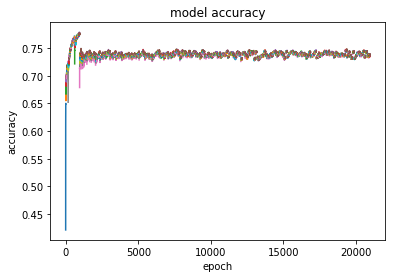

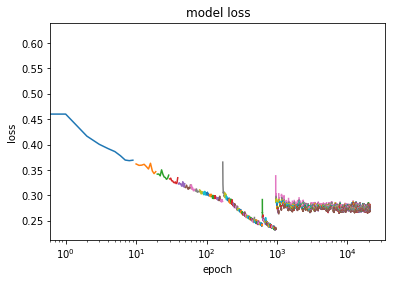

In [158]:
figure()
#print(history3.history.keys())
#plot(history.history['acc'])
#plot(history3.history['acc'])
for i in range(ih):
    plot(arange(10)+i*10,history[i].history['MOC'])

title('model accuracy')
ylabel('accuracy')
xlabel('epoch')
figure()
#plot(history.history['loss'])
#plot(history3.history['loss'])
for i in range(ih):
    plot(arange(10)+i*10,history[i].history['loss'])

title('model loss')
ylabel('loss')
xlabel('epoch')
#yscale("log")
xscale("log")

In [159]:
loss, acc = model.evaluate(Xdev, Ydev)
print("Dev set accuracy = ", acc)

100/100 [==============================] - 1s 9ms/step
Dev set accuracy =  0.8104370164871216


In [123]:
def MOCv(y_true,y_pred):
    '''Just another crossentropy'''
    ly =sum(y_true*y_pred)
    ly2 = sum(y_pred*y_pred)
    ly2l = 1.0*(ly2==0)
    ly2 = ly2+ly2l
    ly3 = sum(y_true*y_true)
    ly3l = 1.0*(ly3==0)
    ly3 = ly3+ly3l
    out = ly/sqrt(ly2*ly3) 
    return out+1.0*ly2l*ly3l


In [ ]:
figure(figsize=(14,4))
i = 800+randint(100)
a = load(datadir+"d"+str(i).zfill(4)+".npy");
b = load(datadir+"o2_"+str(i).zfill(4)+".npy");
subplot(1, 3, 3)
imshow(b)

start = randint(T-500)
end = start+500
xt = a[:,:,start:end]
xt = xt/mean(xt.flatten())
xt = ftvaugment(xt,magn)
xt = reshape(xt,(1,magn*width,magn*height,500,1))
print(xt.shape)
y = model.predict(xt)
print(y.shape)
#print(squeeze(y).shape)
subplot(1, 3, 2)
imshow(squeeze(y))
subplot(1, 3, 1)
imshow(sum(xt[0,:,:,:,0],axis=-1))
print("MOC of prediction = ",MOCv(b,squeeze(y)))
print("MOC of sum = ",MOCv(sum(xt[0,:,:,:,0],axis=-1),b))

In [115]:
print("MOC of prediction = ",MOCv(b,squeeze(y)))
print("MOC of sum = ",MOCv(sum(xt[0,:,:,:,0],axis=-1),b))

MOC of prediction =  0.0
MOC of sum =  0.0


In [94]:
maxb = []
for i in range(900):
    b = load(datadir+"o2_"+str(i).zfill(4)+".npy");
    maxb.append(max(b.flatten()))

In [184]:
sum(array(maxb)<1e-3)/900


0.11333333333333333

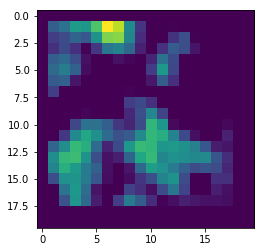

In [50]:
imshow(squeeze(y),vmin= 1.21)

In [157]:
model.save("deepsofi_x2_20180922.h5")
